# MLLB - ML Report
Solal Urien
## I - Introduction
### Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time

### Importing the dataset

In [2]:
path = (
    r'C:\Users\solal\Documents\Documents\Etudes\ETSIT-UPM\Cursos\PRDL-MLLB'
    r'\Final Report\SAHeart.csv'
)
df = pd.read_csv(path)
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


### Data cleaning & description
Firstly, we will drop the column *row.names* as it does not provide any information. In a second time, we will transform the *famhist* column in a format that can be used. We will arbitrarily choose the value **1** for **Present** and **0** for **Absent**.

In [3]:
# Set the pandas option to opt-in to the future behavior in order to avoid the warning
pd.set_option('future.no_silent_downcasting', True)

if 'row.names' in df.columns:
    df.drop('row.names', axis=1, inplace=True)
df.replace('Present', 1, inplace=True)
df.replace('Absent', 0, inplace=True)
df = df.infer_objects(copy=False)
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


An important characteristic that could be observed in our dataset is the correlation between the columns. We therefore plot the correlation matrix to observe this feature.

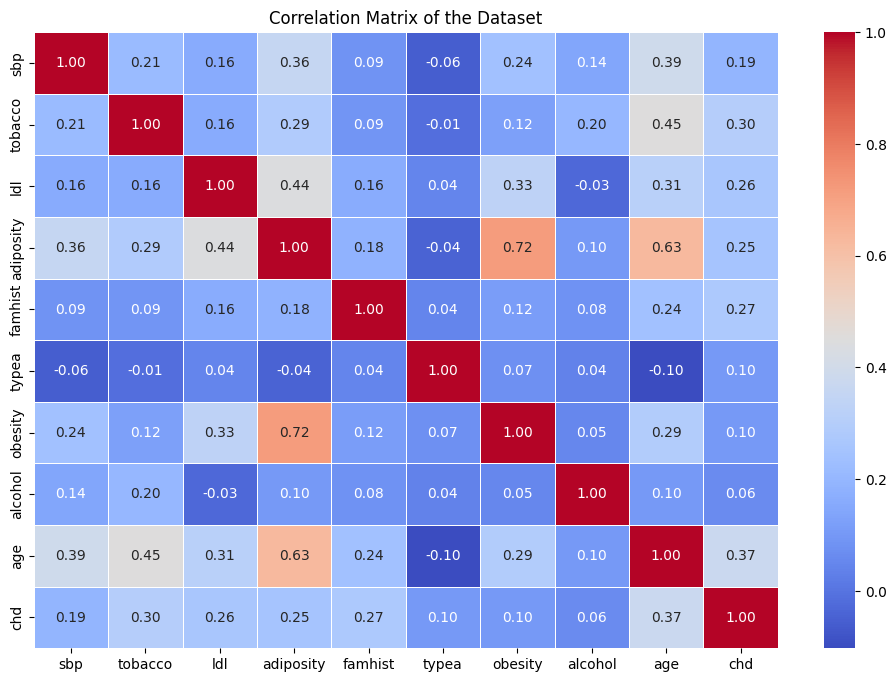

In [4]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')
plt.show()

We can point out two clear correlations: between adiposity and obesity (72% correlation) and between age and adiposity (63% correlation). A simple solution is to delete the adiposity column, which will allow us to reduce multicollinearity in our model and enhance interpretability. By removing the adiposity variable, we can avoid redundancy, as obesity already captures much of the information that adiposity provides.
The rest of the columns seem to be essentially independent of each other.

In [5]:
df.drop('adiposity', axis=1, inplace=True)
df.head()

,sbp,tobacco,ldl,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,1,49,25.30,97.20,52,1
1,144,0.01,4.41,0,55,28.87,2.06,63,1
2,118,0.08,3.48,1,52,29.14,3.81,46,0
3,170,7.50,6.41,1,51,31.99,24.26,58,1
4,134,13.60,3.50,1,60,25.99,57.34,49,1


We will now observe the distribution of each feature in the dataset.

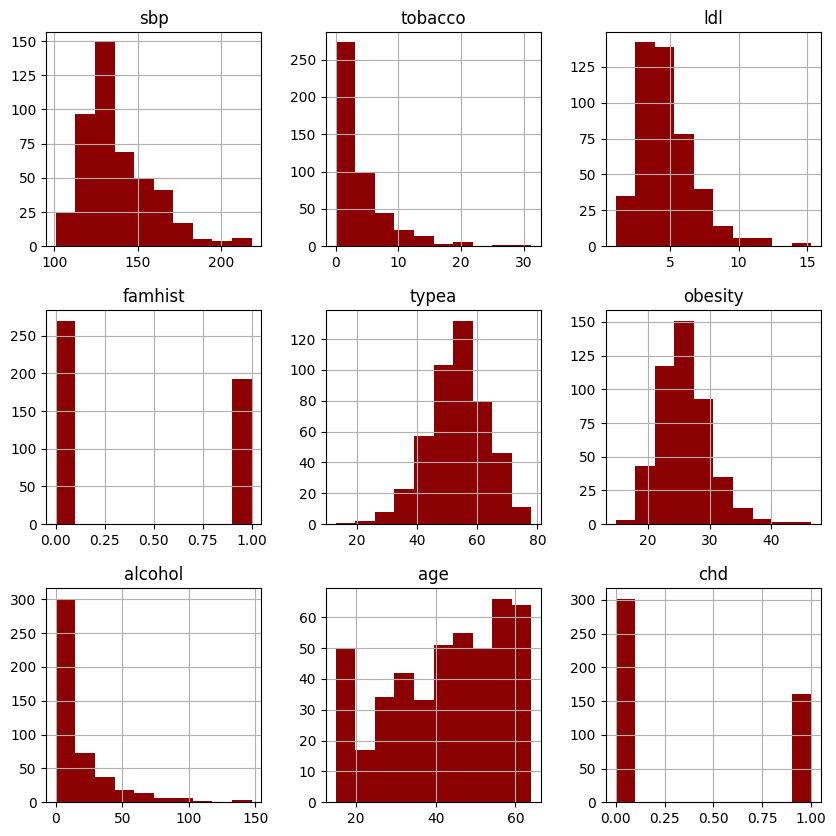

In [6]:
df.hist(figsize=(10, 10), color='darkred')
plt.show()

In terms of sheer distribution, we can observe that tobacco and alcohol both seem to follow an exponential distribution, whereas typea, idl and obesity could be following a normal distribution. We are going to test both hypothesis using Chi-squared and Shapiro-Wilk tests, with the $H_0$ hypothesis being that the aforementioned features follow the respective distributions.

In [7]:
from scipy.stats import expon, chisquare


# Chi-square test for the exponential distribution
def chi_square_test_exponential(data, feature, num_bins=10):
    # Calculate the rate parameter of the exponential distribution
    values = data[feature]
    lambda_ = 1 / np.mean(values)

    bins = np.linspace(values.min(), values.max(), num_bins + 1)
    observed_freq, _ = np.histogram(values, bins=bins)

    expected_freq = np.array([
        expon.cdf(bins[i + 1], scale=1 / lambda_) -
        expon.cdf(bins[i], scale=1 / lambda_)
        for i in range(len(bins) - 1)
    ]) * len(values)

    # Ajuster pour que les sommes des fréquences observées
    # et attendues soient égales
    if not np.isclose(observed_freq.sum(), expected_freq.sum()):
        expected_freq = expected_freq * (observed_freq.sum()
                                         / expected_freq.sum())

    # Effectuer le test du chi-carré
    chi_stat, p_value = chisquare(observed_freq, f_exp=expected_freq)

    return chi_stat, p_value


# Test sur les colonnes 'alcohol' et 'tobacco'
features_to_test = ['tobacco', 'alcohol']
test_results_exponential = {}

for feature in features_to_test:
    chi_stat, p_value = chi_square_test_exponential(df, feature)
    test_results_exponential[feature] = {
        'chi_statistic': chi_stat,
        'p_value': p_value
    }

# Afficher les résultats
for feature, result in test_results_exponential.items():
    print(
        f"Feature: {feature}, Chi-square statistic: {result['chi_statistic']},"
        f"p-value: {result['p_value']}")
    if result['p_value'] > 0.05:
        print("  Accept the model (fail to reject H0)")
    else:
        print("  Reject the model (reject H0)")

Feature: tobacco, Chi-square statistic: 30.48058716902211,p-value: 0.0003632909983401468
  Reject the model (reject H0)
Feature: alcohol, Chi-square statistic: 125.6776232983472,p-value: 9.163823353333519e-23
  Reject the model (reject H0)


In [8]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test
features = ['typea', 'ldl', 'sbp', 'obesity']
results = {}

for feature in features:
    stat, p_value = shapiro(df[feature])
    results[feature] = {'statistic': stat, 'p_value': p_value}

# Display the results
for feature, result in results.items():
    print(f"Feature: {feature}")
    print(f"  Statistic: {result['statistic']}")
    print(f"  P-value: {result['p_value']}")
    if result['p_value'] > 0.05:
        print("The feature follows a normal distribution (fail to reject H0)")
    else:
        print("The feature does not follow a normal distribution "
              "(reject H0)")
    print()

Feature: typea
  Statistic: 0.9913705639291034
  P-value: 0.008603910169591795
The feature does not follow a normal distribution (reject H0)

Feature: ldl
  Statistic: 0.9207456111951928
  P-value: 7.147788376465236e-15
The feature does not follow a normal distribution (reject H0)

Feature: sbp
  Statistic: 0.9230951655961318
  P-value: 1.2527247218092107e-14
The feature does not follow a normal distribution (reject H0)

Feature: obesity
  Statistic: 0.9607445585517455
  P-value: 9.228119680764505e-10
The feature does not follow a normal distribution (reject H0)



Unfortunately, all of the tests were fruitless, and the features do not seem to follow any particular distribution. However, we try another hypothesis: the aforementioned features might follow a Gamma distribution. We test this hypothesis using the Kolmogorov-Smirnov test.

Feature: typea, KS statistic: 0.04702198368945806, p-value: 0.2507684732452262
  The feature follows a gamma distribution (fail to reject H0)


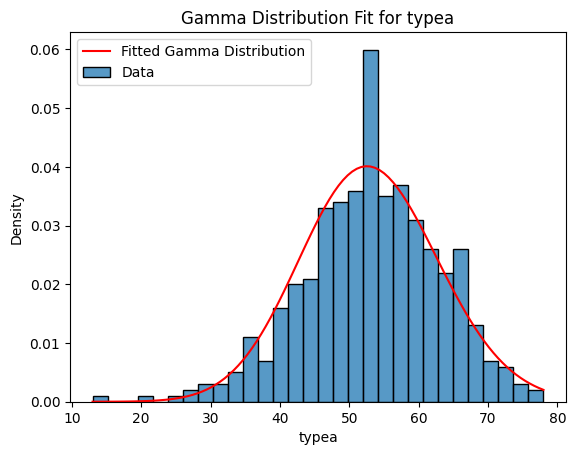


Feature: obesity, KS statistic: 0.029439507634126505, p-value: 0.8068306132597888
  The feature follows a gamma distribution (fail to reject H0)


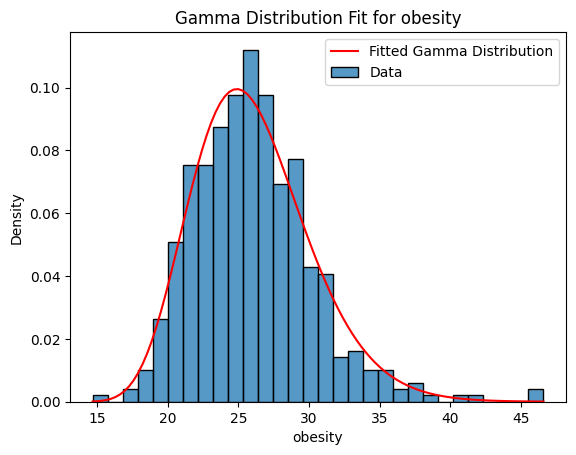


Feature: alcohol, KS statistic: 0.23809523492716775, p-value: 1.5769847748520015e-23
The feature does not follow a gamma distribution (reject H0)

Feature: tobacco, KS statistic: 0.23160173115632599, p-value: 2.847748673452948e-22
The feature does not follow a gamma distribution (reject H0)

Feature: ldl, KS statistic: 0.027235507007766557, p-value: 0.8735051525024397
  The feature follows a gamma distribution (fail to reject H0)


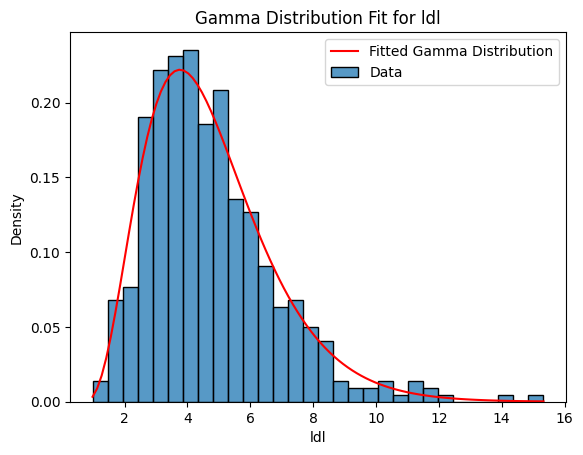


Feature: sbp, KS statistic: 0.07000230555688536, p-value: 0.020563460105825507
The feature does not follow a gamma distribution (reject H0)



In [9]:
from scipy.stats import kstest, gamma


# Function to perform the Kolmogorov-Smirnov test for gamma distribution
def ks_test_gamma(data, feature):
    # Fit the gamma distribution to the data
    params = gamma.fit(data[feature])

    # Perform the Kolmogorov-Smirnov test
    D, p_value = kstest(data[feature], 'gamma', args=params)

    return D, p_value, params


# Test on the columns 'typea', 'obesity', 'alcohol', 'tobacco', 'ldl', 'sbp'
features_to_test_gamma = ['typea', 'obesity',
                          'alcohol', 'tobacco', 'ldl', 'sbp']
test_results_gamma = {}

for feature in features_to_test_gamma:
    D, p_value, params = ks_test_gamma(df, feature)
    test_results_gamma[feature] = {'ks_statistic': D,
                                   'p_value': p_value, 'params': params}

# Display the results and plot the curve if the gamma distribution fits
for feature, result in test_results_gamma.items():
    print(f"Feature: {feature}, KS statistic: {result['ks_statistic']}, p-value: {result['p_value']}")
    if result['p_value'] > 0.05:
        print("  The feature follows a gamma distribution (fail to reject H0)")

        # Plot the histogram of the data
        sns.histplot(df[feature], kde=False, stat='density', bins=30, label='Data')

        # Plot the fitted gamma distribution
        x = np.linspace(df[feature].min(), df[feature].max(), 100)
        plt.plot(x, gamma.pdf(x, *result['params']), label='Fitted Gamma Distribution', color='red')

        plt.title(f'Gamma Distribution Fit for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    else:
        print("The feature does not follow a gamma distribution (reject H0)")
    print()

## II - First machine learning algorithms
### Logistic regression

Average Accuracy: 0.7217
Best Accuracy: 0.8065
Worst Accuracy: 0.6452
Average Computational Time: 0.0180 seconds


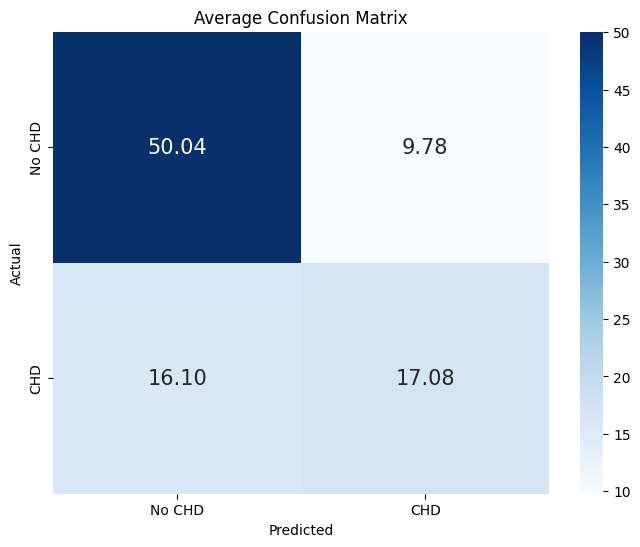

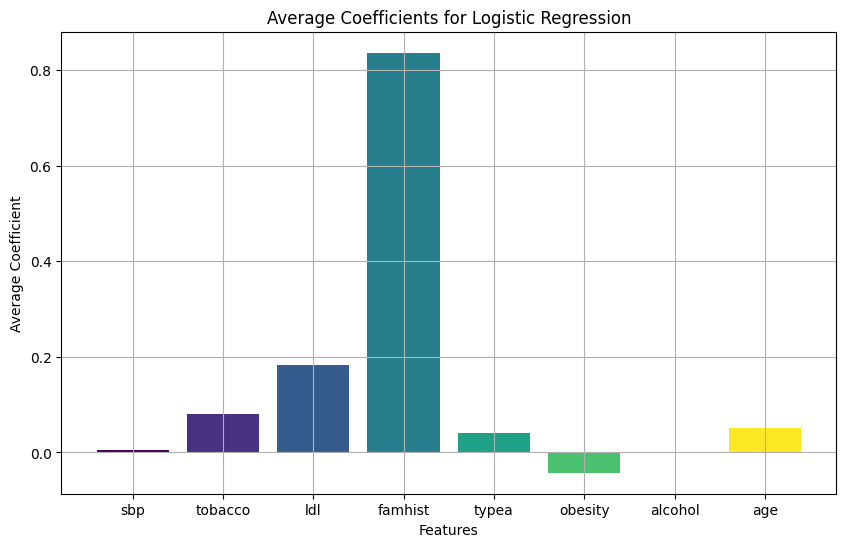

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the features and the target variable
X = df.drop('chd', axis=1)
y = df['chd']

# Initialize variables to store the results
classification_reports = []
confusion_matrices = []
intercepts = []
coefficients_list = []
times = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    start_time = time.time()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Initialize the logistic regression model
    log_reg = LogisticRegression(max_iter=1000)
    
    # Train the model
    log_reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = log_reg.predict(X_test)
    
    # Evaluate the model
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    intercepts.append(log_reg.intercept_[0])
    coefficients_list.append(log_reg.coef_.flatten())
    
    end_time = time.time()
    times.append(end_time - start_time)

# Extract relevant metrics from classification reports
metrics = ['precision', 'recall', 'f1-score', 'support']
avg_classification_report = {}

for label in classification_reports[0].keys():
    avg_classification_report[label] = {}
    for metric in metrics:
        # Ensure the value is a dictionary before accessing its metrics
        if isinstance(classification_reports[0][label], dict):
            avg_classification_report[label][metric] = np.mean([report[label][metric] for report in classification_reports if isinstance(report[label], dict)])
        else:
            avg_classification_report[label][metric] = np.mean([report[label] for report in classification_reports])

# Calculate the average confusion matrix
avg_confusion_matrix_logistic = np.mean(confusion_matrices, axis=0)

# Calculate the average accuracy
accuracies = [report['accuracy'] for report in classification_reports]
avg_accuracy = np.mean(accuracies)

# Print the average accuracy
print(f"Average Accuracy: {avg_accuracy:.4f}")

# Store the average accuracy
average_accuracy_logistic = avg_accuracy

# Find and store the best and worst accuracies
best_accuracy_logistic = max(accuracies)
worst_accuracy_logistic = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_logistic:.4f}")
print(f"Worst Accuracy: {worst_accuracy_logistic:.4f}")


# Calculate and print the average computational time
avg_time_logistic = np.mean(times)
print(f"Average Computational Time: {avg_time_logistic:.4f} seconds")

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_logistic, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix')
plt.show()

# Calculate the average coefficients
avg_coefficients = np.mean(coefficients_list, axis=0)

# Plot the average coefficients with different colors for each bar
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(X.columns)))
plt.bar(X.columns, avg_coefficients, color=colors)
plt.xlabel('Features')
plt.grid()
plt.ylabel('Average Coefficient')
plt.title('Average Coefficients for Logistic Regression')
plt.show()

### Decision tree

Average Accuracy: 0.7181
Best Accuracy: 0.7957
Worst Accuracy: 0.6452
Average Best Depth: 3.56
Average Computational Time: 0.0522 seconds


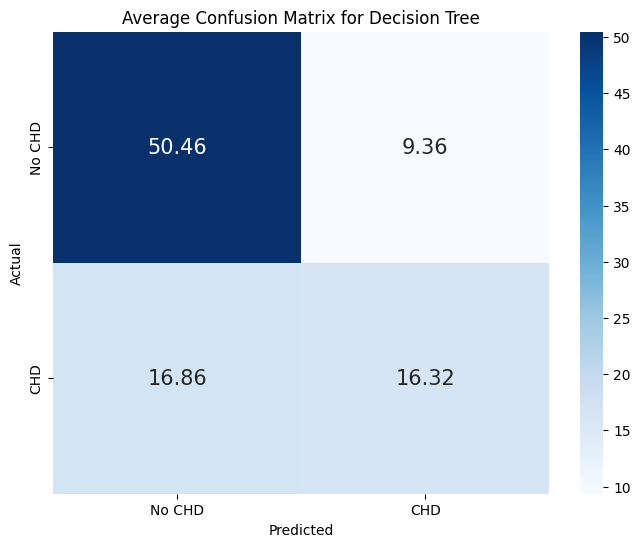

Depth of the representative decision tree: 4
Accuracy of the representative decision tree: 0.7419


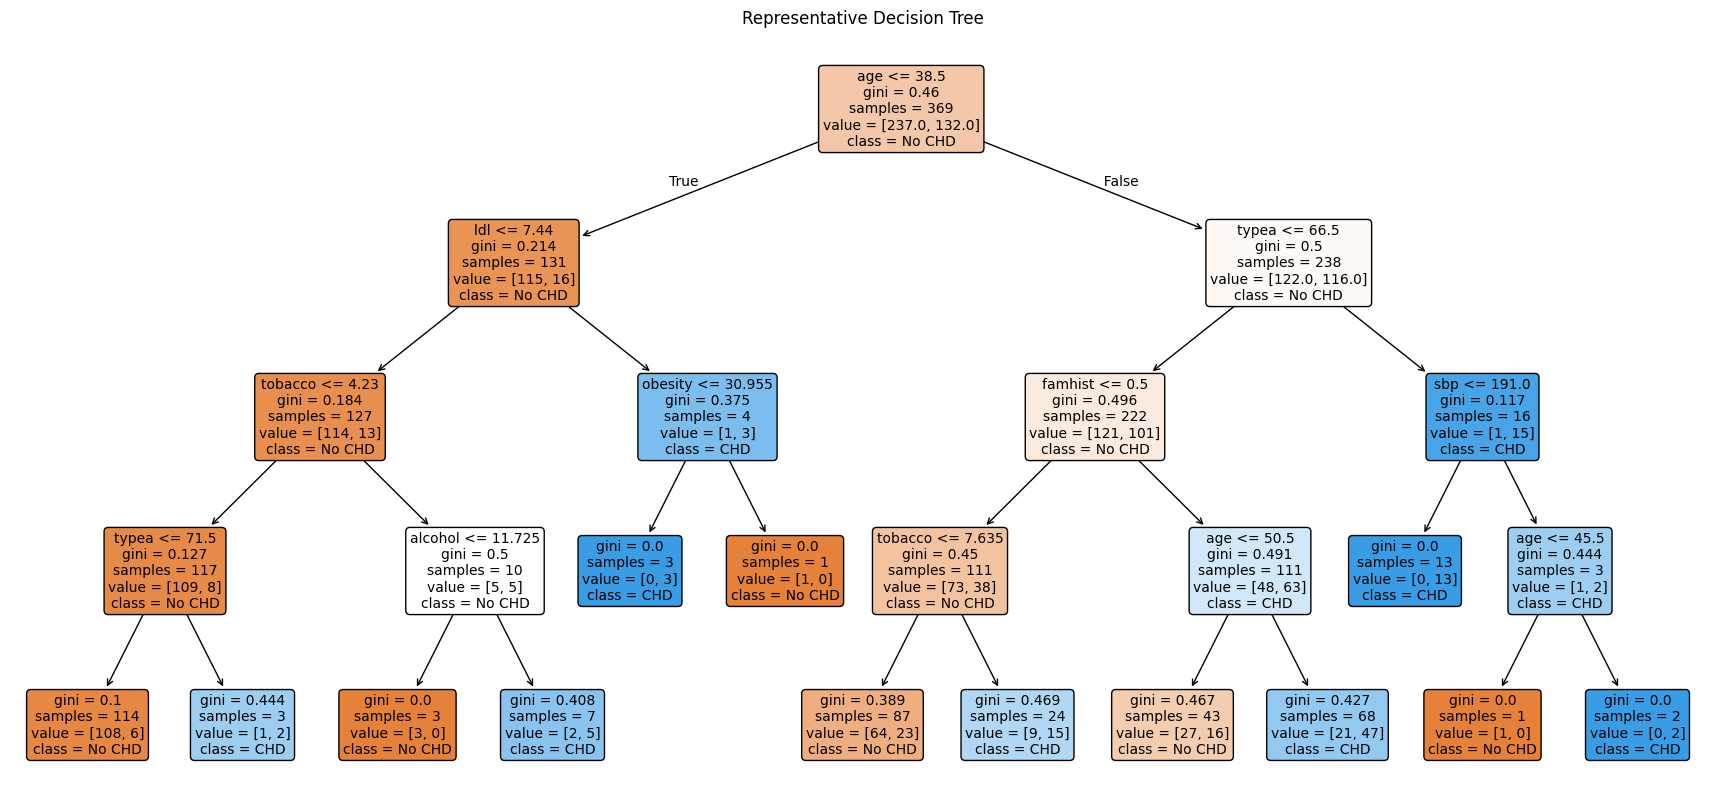

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize variables to store the results
confusion_matrices = []
accuracies = []
times = []
classifiers = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    start_time = time.time()
    best_accuracy = 0
    best_depth = None
    best_dt_classifier = None
    y_pred_best = None

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Find the best depth for the current random state
    for depth in range(1, 15):
        dt_classifier = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        dt_classifier.fit(X_train, y_train)
        
        y_pred_dt = dt_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_dt)
    
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth
            best_dt_classifier = dt_classifier
            y_pred_best = y_pred_dt
    
    end_time = time.time()
    times.append(end_time - start_time)
    
    # Calculate the confusion matrix
    conf_matrix_dt = confusion_matrix(y_test, y_pred_best)
    confusion_matrices.append(conf_matrix_dt)
    accuracies.append(best_accuracy)
    classifiers.append(best_dt_classifier)

# Calculate the average accuracy
avg_accuracy_decision_tree = np.mean(accuracies)
print(f"Average Accuracy: {avg_accuracy_decision_tree:.4f}")

# Find & store the best and worst accuracies
best_accuracy_decision_tree = max(accuracies)
worst_accuracy_decision_tree = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_decision_tree:.4f}")
print(f"Worst Accuracy: {worst_accuracy_decision_tree:.4f}")

# Calculate the average best depth
avg_best_depth = np.mean([classifier.get_depth() for classifier in classifiers])
print(f"Average Best Depth: {avg_best_depth}")

# Calculate and print the average computational time
avg_time_decision_tree = np.mean(times)
print(f"Average Computational Time: {avg_time_decision_tree:.4f} seconds")

# Calculate the average confusion matrix
avg_confusion_matrix_decision_tree = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_decision_tree, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix for Decision Tree')
plt.show()

# Find the representative decision tree
closest_depth_diff = float('inf')
closest_accuracy_diff = float('inf')
representative_classifier = None

for classifier in classifiers:
    depth_diff = abs(classifier.get_depth() - avg_best_depth)
    accuracy_diff = abs(classifier.score(X_test, y_test) - avg_accuracy_decision_tree)
    
    if depth_diff < closest_depth_diff or (depth_diff == closest_depth_diff and accuracy_diff < closest_accuracy_diff):
        closest_depth_diff = depth_diff
        closest_accuracy_diff = accuracy_diff
        representative_classifier = classifier

print(f"Depth of the representative decision tree: {representative_classifier.get_depth()}")
print(f"Accuracy of the representative decision tree: {representative_classifier.score(X_test, y_test):.4f}")

# Plot the representative decision tree
plt.figure(figsize=(22, 10))
plot_tree(representative_classifier, feature_names=X.columns, class_names=['No CHD', 'CHD'], filled=True, rounded=True, fontsize=10)
plt.title('Representative Decision Tree')
plt.show()

### Naive Bayes

Average Accuracy: 0.6615
Best Accuracy: 0.7957
Worst Accuracy: 0.5484
Average Computational Time: 0.0091 seconds


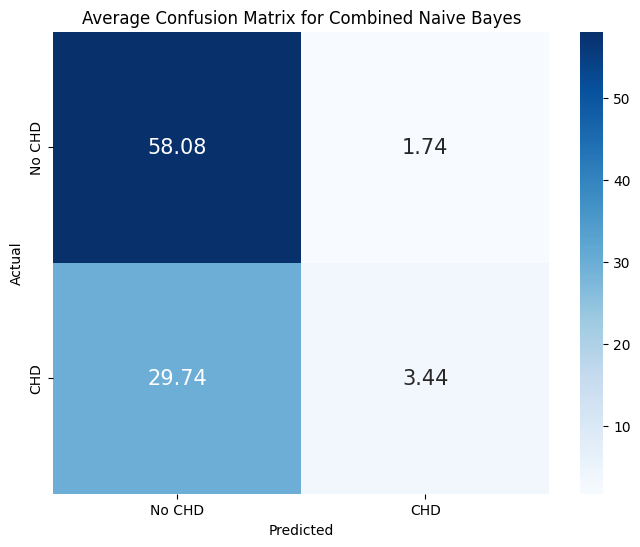

In [12]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df[['sbp', 'tobacco', 'ldl', 'famhist', 'typea', 'obesity', 'alcohol', 'age']]
y = df['chd']

# Initialize variables to store the results
accuracies = []
confusion_matrices = []
times = []

# Run the algorithm for 50 different random sets
for random_state in range(50):
    start_time = time.time()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Standardize the continuous features (for Gaussian NB)
    scaler = StandardScaler()
    X_train_cont = scaler.fit_transform(X_train[['sbp', 'tobacco', 'ldl', 'typea', 'obesity', 'alcohol', 'age']])
    X_test_cont = scaler.transform(X_test[['sbp', 'tobacco', 'ldl', 'typea', 'obesity', 'alcohol', 'age']])

    # Extract binary feature
    X_train_bin = X_train[['famhist']].values
    X_test_bin = X_test[['famhist']].values

    # GaussianNB for continuous features
    gnb = GaussianNB()
    gnb.fit(X_train_cont, y_train)

    # BernoulliNB for binary feature
    bnb = BernoulliNB()
    bnb.fit(X_train_bin, y_train)

    # Predict with GaussianNB for continuous features
    y_pred_cont = gnb.predict(X_test_cont)

    # Predict with BernoulliNB for binary feature
    y_pred_bin = bnb.predict(X_test_bin)

    # Combine predictions using a voting mechanism (for simplicity, you could average the predictions)
    y_pred_combined = np.round((y_pred_cont + y_pred_bin) / 2)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_combined)
    accuracies.append(accuracy)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_combined)
    confusion_matrices.append(conf_matrix)
    
    end_time = time.time()
    times.append(end_time - start_time)

# Calculate the average accuracy
avg_accuracy_naive_bayes = np.mean(accuracies)
print(f"Average Accuracy: {avg_accuracy_naive_bayes:.4f}")

# Find & store the best and worst accuracies
best_accuracy_naive_bayes = max(accuracies)
worst_accuracy_naive_bayes = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_naive_bayes:.4f}")
print(f"Worst Accuracy: {worst_accuracy_naive_bayes:.4f}")

# Calculate and print the average computational time
avg_time_naive_bayes = np.mean(times)
print(f"Average Computational Time: {avg_time_naive_bayes:.4f} seconds")

# Calculate the average confusion matrix
avg_confusion_matrix_naives_bayes = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_naives_bayes, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix for Combined Naive Bayes')
plt.show()

### K-Nearest Neighbours (KNN)

Average Accuracy for KNN: 0.7125
Best Accuracy: 0.8065
Worst Accuracy: 0.6237
Average Computational Time for KNN: 1.1666 seconds


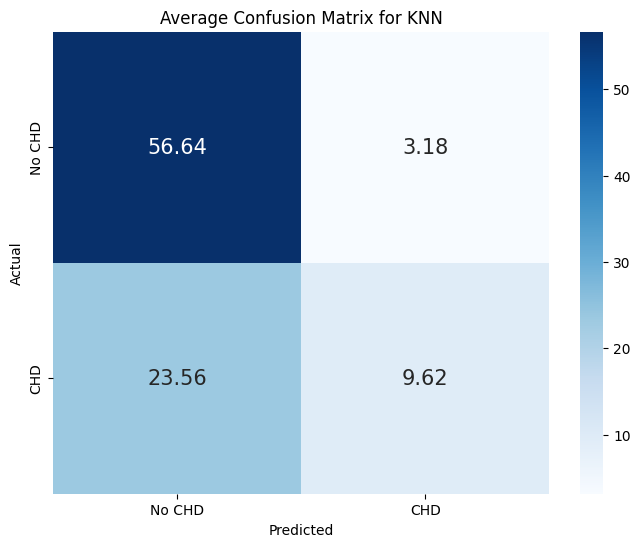

Average Best n_neighbors for KNN: 42.1


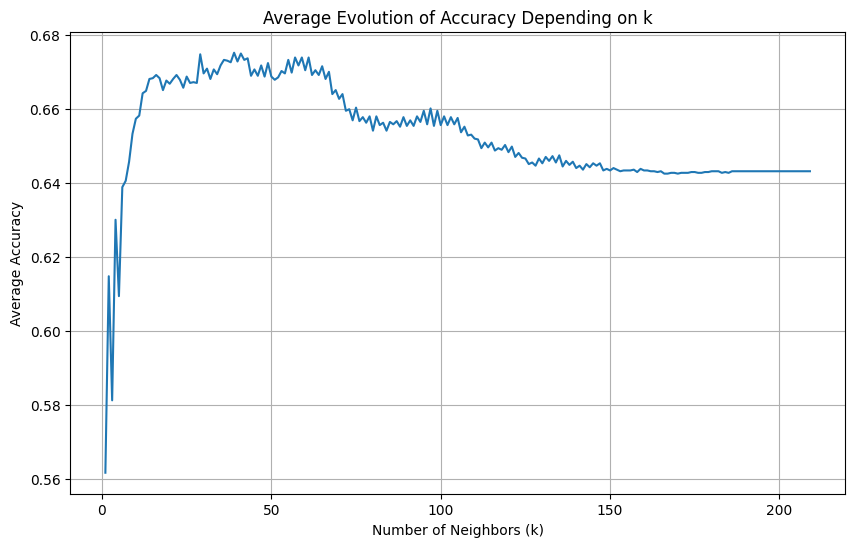

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize variables to store the results
confusion_matrices = []
accuracies = []
best_n_neighbors_list = []
n_neighbors_accuracies = {n: [] for n in range(1, 210)}
times = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    start_time = time.time()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    best_accuracy = 0
    best_n_neighbors = None
    best_knn = None

    # Find the best n_neighbors for the current random state
    for n_neighbors in range(1, 210):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        accuracy_knn = accuracy_score(y_test, y_pred_knn)
        
        n_neighbors_accuracies[n_neighbors].append(accuracy_knn)
        
        if accuracy_knn > best_accuracy:
            best_accuracy = accuracy_knn
            best_n_neighbors = n_neighbors
            best_knn = knn
        
        # Stop the timer when n_neighbors reaches 60
        if n_neighbors == 60:
            end_time = time.time()
            times.append(end_time - start_time)

    # Train the best model for the current random state
    best_knn.fit(X_train, y_train)
    y_pred_knn = best_knn.predict(X_test)
    
    # Evaluate the model
    accuracies.append(best_accuracy)
    best_n_neighbors_list.append(best_n_neighbors)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_knn)
    confusion_matrices.append(conf_matrix)

# Calculate the average accuracy
avg_accuracy_knn = np.mean(accuracies)
print(f"Average Accuracy for KNN: {avg_accuracy_knn:.4f}")

# Find & store the best and worst accuracies
best_accuracy_knn = max(accuracies)
worst_accuracy_knn = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_knn:.4f}")
print(f"Worst Accuracy: {worst_accuracy_knn:.4f}")

# Calculate and print the average computational time
avg_time_knn = np.mean(times)
print(f"Average Computational Time for KNN: {avg_time_knn:.4f} seconds")

# Calculate the average confusion matrix
avg_confusion_matrix_knn = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_knn, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix for KNN')
plt.show()

# Calculate the average best n_neighbors
avg_best_n_neighbors = np.mean(best_n_neighbors_list)
print("Average Best n_neighbors for KNN:", avg_best_n_neighbors)

# Plot the average evolution of accuracy depending on k
avg_accuracies_per_k = {k: np.mean(acc) for k, acc in n_neighbors_accuracies.items()}
plt.figure(figsize=(10, 6))
plt.plot(list(avg_accuracies_per_k.keys()), list(avg_accuracies_per_k.values()))
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Accuracy')
plt.title('Average Evolution of Accuracy Depending on k')
plt.grid()
plt.show()

### Support Vector Machine
Firstly, we will plot an example to show how the linear kernel SVM classifier separates classes with a hyperplane.

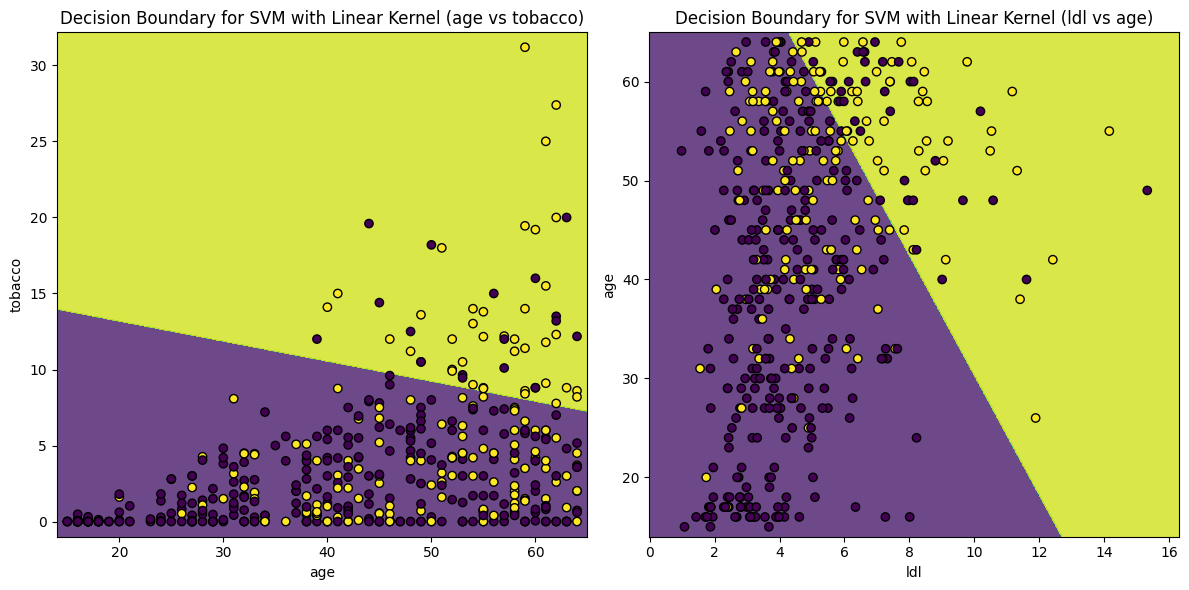

In [14]:
from sklearn.svm import SVC

# Function to plot decision boundary for 2D
def plot_decision_boundary_2d(X, y, model, ax, feature_names):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])

# Define the pairs of features to visualize
feature_pairs = [
    ('age', 'tobacco'),
    ('ldl', 'age')]

# Create subplots
fig, axes = plt.subplots(1, len(feature_pairs), figsize=(12, 6))

# Plot decision boundaries for each pair of features
for ax, feature_pair in zip(axes, feature_pairs):
    X_pair = X[list(feature_pair)].values
    
    # Train the SVM model on the selected features
    svm_pair = SVC(kernel='linear', random_state=0)
    svm_pair.fit(X_pair, y)
    
    # Plot the decision boundary
    plot_decision_boundary_2d(X_pair, y, svm_pair, ax, feature_pair)
    ax.set_title(f'Decision Boundary for SVM with Linear Kernel ({feature_pair[0]} vs {feature_pair[1]})')

plt.tight_layout()
plt.show()

We then apply the algorithm to the entire dataset and display the results.

Average Accuracy for SVM: 0.7124731182795699
Best Accuracy: 0.8172
Worst Accuracy: 0.6452
Average Computational Time for SVM: 0.4063 seconds


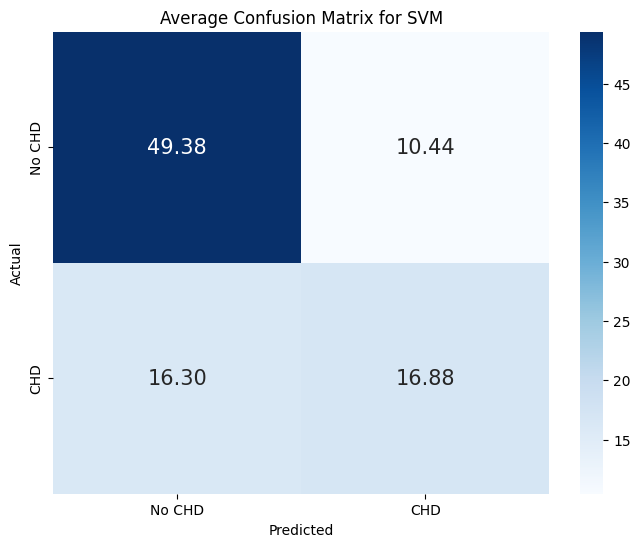

In [15]:
# Initialize variables to store the results
confusion_matrices = []
accuracies = []
times = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    start_time = time.time()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Initialize the SVM model
    svm = SVC(kernel='linear', random_state=random_state)
    
    # Train the model
    svm.fit(X_train, y_train)
    
    # Make predictions
    y_pred_svm = svm.predict(X_test)
    
    # Evaluate the model
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    accuracies.append(accuracy_svm)
    
    # Calculate the confusion matrix
    conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
    confusion_matrices.append(conf_matrix_svm)
    
    end_time = time.time()
    times.append(end_time - start_time)

# Calculate the average accuracy
avg_accuracy_svm = np.mean(accuracies)
print("Average Accuracy for SVM:", avg_accuracy_svm)

# Find & store the best and worst accuracies
best_accuracy_svm = max(accuracies)
worst_accuracy_svm = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_svm:.4f}")
print(f"Worst Accuracy: {worst_accuracy_svm:.4f}")

# Calculate and print the average computational time
avg_time_svm = np.mean(times)
print(f"Average Computational Time for SVM: {avg_time_svm:.4f} seconds")

# Calculate the average confusion matrix
avg_confusion_matrix_svm = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_svm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix for SVM')
plt.show()

### Conclusion & comparison

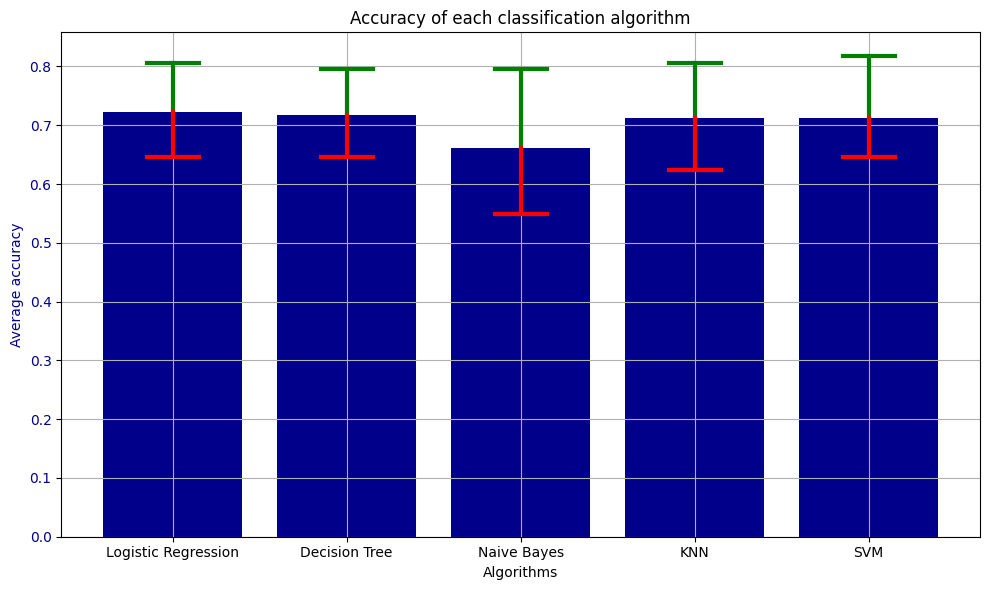

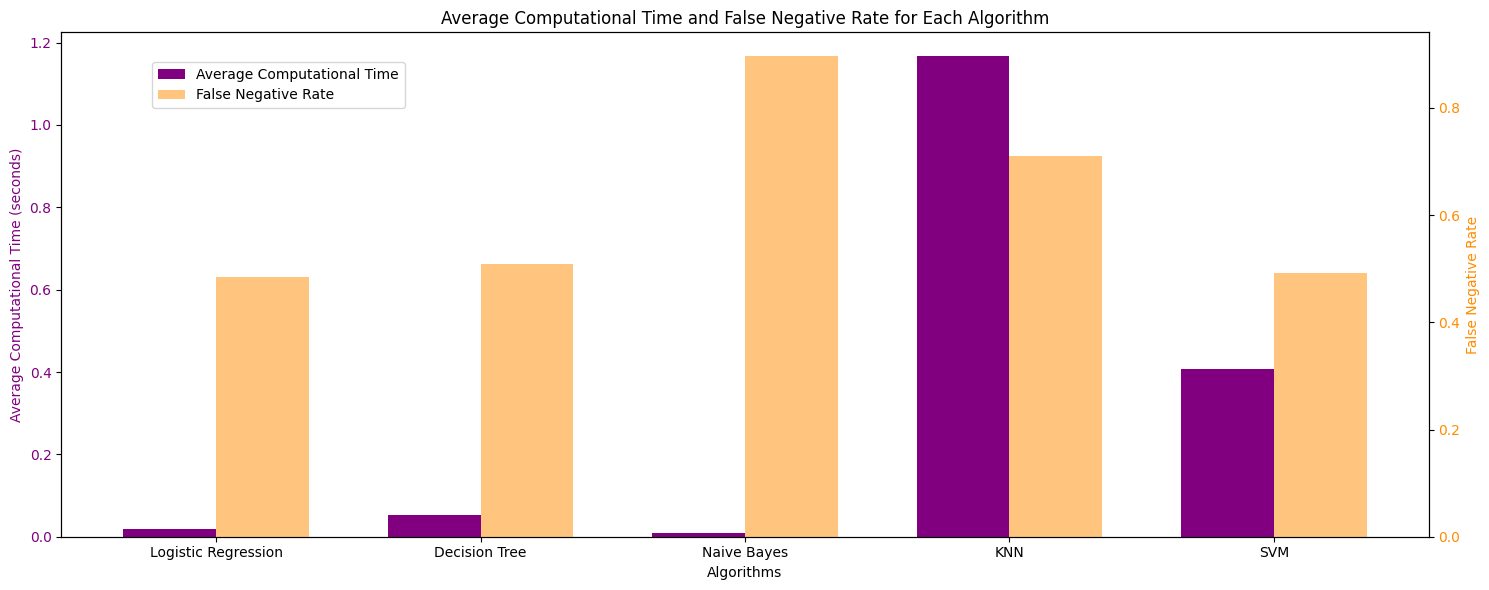

In [16]:
# Extract the average accuracy and false negative rate from the previous results
algorithms = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'KNN', 'SVM']
avg_accuracies = [average_accuracy_logistic,
                  avg_accuracy_decision_tree,
                  avg_accuracy_naive_bayes,
                  avg_accuracy_knn,
                  avg_accuracy_svm]

# Calculate the average false negative rates
avg_false_negative_rates = [
    avg_confusion_matrix_logistic[1][0] / (avg_confusion_matrix_logistic[1][0] + avg_confusion_matrix_logistic[1][1]),
    avg_confusion_matrix_decision_tree[1][0] / (avg_confusion_matrix_decision_tree[1][0] + avg_confusion_matrix_decision_tree[1][1]),
    avg_confusion_matrix_naives_bayes[1][0] / (avg_confusion_matrix_naives_bayes[1][0] + avg_confusion_matrix_naives_bayes[1][1]),
    avg_confusion_matrix_knn[1][0] / (avg_confusion_matrix_knn[1][0] + avg_confusion_matrix_knn[1][1]),
    avg_confusion_matrix_svm[1][0] / (avg_confusion_matrix_svm[1][0] + avg_confusion_matrix_svm[1][1])
]

# Extract the best and worst accuracies
best_accuracies = [best_accuracy_logistic, best_accuracy_decision_tree, best_accuracy_naive_bayes, best_accuracy_knn, best_accuracy_svm]
worst_accuracies = [worst_accuracy_logistic, worst_accuracy_decision_tree, worst_accuracy_naive_bayes, worst_accuracy_knn, worst_accuracy_svm]

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average accuracy
bars = ax1.bar(algorithms, avg_accuracies, color='darkblue', label='Average Accuracy')

# Plot best and worst accuracy
horizontal_line_width = 0.3
for i, (mean, best, worst) in enumerate(zip(avg_accuracies, best_accuracies, worst_accuracies)):

    # Plot best accuracy
    left = i - horizontal_line_width / 2
    top = best
    right = i + horizontal_line_width / 2
    bottom = best
    plt.plot([i, i], [mean, best], color='green', linewidth=3)
    plt.plot([left, right], [top, top], color='green', linewidth=3)

    # Plot worst accuracy
    left = i - horizontal_line_width / 2
    top = worst
    right = i + horizontal_line_width / 2
    bottom = worst
    plt.plot([i, i], [mean, worst], color='red', linewidth=3)
    plt.plot([left, right], [top, top], color='red', linewidth=3)

ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Average accuracy', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')


# Add title and legend
plt.title('Accuracy of each classification algorithm')
fig.tight_layout()
plt.grid()
plt.show()

# Extract the average computational times
avg_times = [avg_time_logistic,
             avg_time_decision_tree,
             avg_time_naive_bayes,
             avg_time_knn,
             avg_time_svm]

# Plot the computational times and false negative rates
fig, ax1 = plt.subplots(figsize=(15, 6))

# Define the width of the bars
bar_width = 0.35

# Define the positions of the bars
r1 = np.arange(len(algorithms))
r2 = [x + bar_width for x in r1]

# Plot average computational time
bars1 = ax1.bar(r1, avg_times, color='purple', width=bar_width, label='Average Computational Time')
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Average Computational Time (seconds)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Create a second y-axis to plot false negative rate
ax2 = ax1.twinx()

# Plot false negative rate as a bar plot
bars2 = ax2.bar(r2, avg_false_negative_rates, color='darkorange', width=bar_width, alpha=0.5, label='False Negative Rate')

ax2.set_ylabel('False Negative Rate', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Add title and legend
plt.title('Average Computational Time and False Negative Rate for Each Algorithm')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks([r + bar_width / 2 for r in range(len(algorithms))], algorithms)
plt.show()

## III - Improvement of the previous models
### Logistic Regression
#### Finding the best hyperparameter using cross validation

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the parameter grid for hyperparameter tuning
param_grid = {'C': np.linspace(0.75, 0.85, 10)}

# Initialize variables to store the results
opt_params_list = []

# Run the GridSearchCV for 50 different random states
for random_state in range(50):
    # Initialize the logistic regression model
    log_reg = LogisticRegression(max_iter=1000, random_state= random_state, solver='lbfgs',tol=1e-4)

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    
    # Get the best hyperparameters
    opt_params = grid_search.best_params_
    opt_params_list.append(opt_params)

# Calculate the average best hyperparameters
avg_opt_params = np.mean([float(params['C']) for params in opt_params_list])
print(f"Average best hyperparameters: {avg_opt_params}")

Average best hyperparameters: 0.8166666666666668


#### Using the best hyperparameter in our previous experiment

Average Accuracy: 0.7209
Best Accuracy: 0.8065
Worst Accuracy: 0.6452
Average Computational Time: 0.0179 seconds


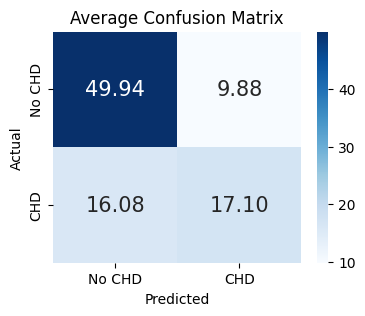

In [18]:
# Define the features and the target variable
X = df.drop('chd', axis=1)
y = df['chd']

# Initialize variables to store the results
classification_reports = []
confusion_matrices = []
intercepts = []
coefficients_list = []
times = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    start_time = time.time()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Initialize the logistic regression model
    log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', tol = 1e-4, C=avg_opt_params)
    
    # Train the model
    log_reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = log_reg.predict(X_test)
    
    # Evaluate the model
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    intercepts.append(log_reg.intercept_[0])
    coefficients_list.append(log_reg.coef_.flatten())
    
    end_time = time.time()
    times.append(end_time - start_time)

# Extract relevant metrics from classification reports
metrics = ['precision', 'recall', 'f1-score', 'support']
avg_classification_report = {}

for label in classification_reports[0].keys():
    avg_classification_report[label] = {}
    for metric in metrics:
        # Ensure the value is a dictionary before accessing its metrics
        if isinstance(classification_reports[0][label], dict):
            avg_classification_report[label][metric] = np.mean([report[label][metric] for report in classification_reports if isinstance(report[label], dict)])
        else:
            avg_classification_report[label][metric] = np.mean([report[label] for report in classification_reports])

# Calculate the average confusion matrix
avg_confusion_matrix_logistic_opt = np.mean(confusion_matrices, axis=0)

# Calculate the average accuracy
accuracies = [report['accuracy'] for report in classification_reports]
avg_accuracy = np.mean(accuracies)

# Store the average accuracy
average_accuracy_logistic_opt = avg_accuracy

# Print the average accuracy
print(f"Average Accuracy: {average_accuracy_logistic_opt:.4f}")

# Find & store the best and worst accuracies
best_accuracy_logistic_opt = max(accuracies)
worst_accuracy_logistic_opt = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_logistic_opt:.4f}")
print(f"Worst Accuracy: {worst_accuracy_logistic_opt:.4f}")

# Calculate and print the average computational time
avg_time_logistic_opt = np.mean(times)
print(f"Average Computational Time: {avg_time_logistic_opt:.4f} seconds")

# Plot the average confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(avg_confusion_matrix_logistic_opt, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix')
plt.show()

# Calculate the average coefficients
avg_coefficients_opt = np.mean(coefficients_list, axis=0)

In [19]:
# Create a DataFrame to hold the comparison data
comparison_data = {
    'Metric': ['Average Accuracy', 'False Negative Rate', 'Best Accuracy', 'Worst Accuracy'],
    'First Logistic Regression': [
        round(average_accuracy_logistic, 4), 
        round(avg_confusion_matrix_logistic[1][0] / (avg_confusion_matrix_logistic[1][0] + avg_confusion_matrix_logistic[1][1]), 4),
        round(best_accuracy_logistic, 4),
        round(worst_accuracy_logistic, 4)
    ],
    'Optimized Logistic Regression': [
        round(average_accuracy_logistic_opt, 4), 
        round(avg_confusion_matrix_logistic_opt[1][0] / (avg_confusion_matrix_logistic_opt[1][0] + avg_confusion_matrix_logistic_opt[1][1]), 4),
        round(best_accuracy_logistic_opt, 4),
        round(worst_accuracy_logistic_opt, 4)
    ]
}

# Add percentage comparison
comparison_data['Percentage Change'] = [
    f"{round((comparison_data['Optimized Logistic Regression'][0] - comparison_data['First Logistic Regression'][0]) / comparison_data['First Logistic Regression'][0] * 100, 2)}%",
    f"{round((comparison_data['Optimized Logistic Regression'][1] - comparison_data['First Logistic Regression'][1]) / comparison_data['First Logistic Regression'][1] * 100, 2)}%",
    f"{round((comparison_data['Optimized Logistic Regression'][2] - comparison_data['First Logistic Regression'][2]) / comparison_data['First Logistic Regression'][2] * 100, 2)}%",
    f"{round((comparison_data['Optimized Logistic Regression'][3] - comparison_data['First Logistic Regression'][3]) / comparison_data['First Logistic Regression'][3] * 100, 2)}%"
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df


,Metric,First Logistic Regression,Optimized Logistic Regression,Percentage Change
0,Average Accuracy,0.7217,0.7209,-0.11%
1,False Negative Rate,0.4852,0.4846,-0.12%
2,Best Accuracy,0.8065,0.8065,0.0%
3,Worst Accuracy,0.6452,0.6452,0.0%


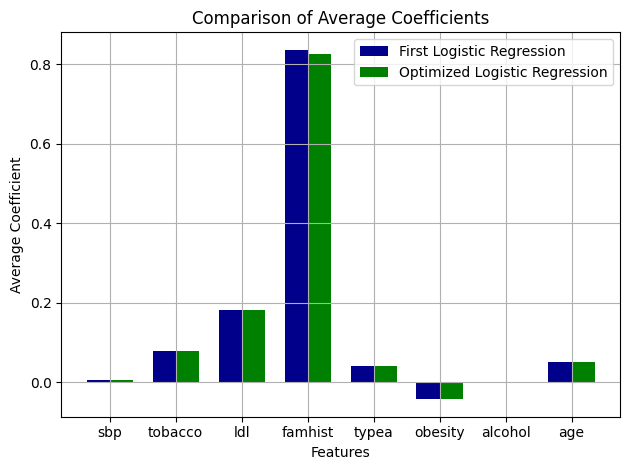

In [20]:
# Define the x locations for the groups
x = np.arange(len(X.columns))

# Plot the average coefficients comparison
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.35/2, avg_coefficients, 0.35, label='First Logistic Regression', color='darkblue')
rects2 = ax.bar(x + 0.35/2, avg_coefficients_opt, 0.35, label='Optimized Logistic Regression', color='green')
ax.set_xlabel('Features')
ax.set_ylabel('Average Coefficient')
ax.set_title('Comparison of Average Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(X.columns)
ax.legend()
fig.tight_layout()
plt.grid()
plt.show()

### Upgrading Decision Trees to Random Forests
After our first trials, we obtained a list of the best estimators (between 1 and 200) for each random state. We used it to lower the algorithm computational time.

[1, 2, 5, 7, 9, 11, 12, 13, 15, 16, 18, 21, 22, 23, 24, 25, 26, 27, 29, 32, 39, 42, 45, 54, 68, 75, 79, 84, 100, 107, 112, 116, 125, 140, 143, 155, 157, 182, 194]
Length of the list: 39


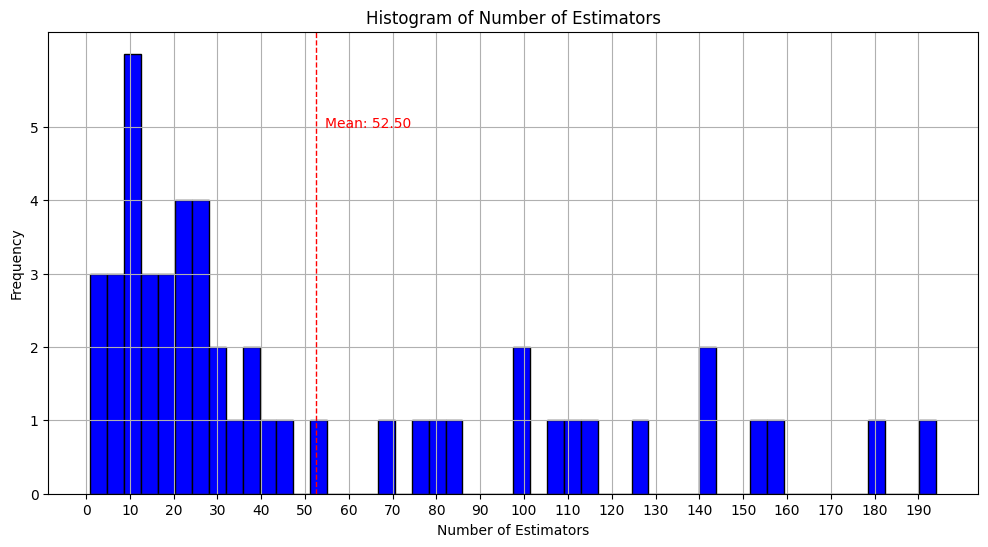

In [21]:
# Data
best_estimators = [
    23, 27, 100, 39, 26, 12, 100, 112, 2, 1, 45, 79, 9, 16, 18, 13, 25, 11, 84, 39,
    125, 9, 7, 54, 107, 18, 157, 155, 194, 143, 11, 32, 2, 7, 75, 29, 15, 42, 25, 21,
    116, 5, 18, 12, 22, 182, 29, 68, 24, 140
]

# Sort the best_estimators list and remove duplicates
best_estimators_sorted = sorted(set(best_estimators))
print(best_estimators_sorted)
print("Length of the list:", len(best_estimators_sorted))

# Calculate the mean of best estimators
mean_best_estimators = np.mean(best_estimators)

# Plot histogram of number of estimators
plt.figure(figsize=(12, 6))
plt.hist(best_estimators, bins=50, color='blue', edgecolor='black')
plt.axvline(mean_best_estimators, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_best_estimators + 2, 5, f'Mean: {mean_best_estimators:.2f}', color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Estimators')
plt.xticks(np.arange(0, max(best_estimators) + 1, 10))  # Set x-axis ticks with a step of 10
plt.yticks(np.arange(0, 6, 1))  # Set y-axis ticks with a step of 1
plt.grid(True)
plt.show()

Best accuracy for random state 0: 0.7419, Best number of estimators: 23
Best accuracy for random state 1: 0.8172, Best number of estimators: 27
Best accuracy for random state 2: 0.7419, Best number of estimators: 100
Best accuracy for random state 3: 0.7527, Best number of estimators: 39
Best accuracy for random state 4: 0.7312, Best number of estimators: 26
Best accuracy for random state 5: 0.7419, Best number of estimators: 12
Best accuracy for random state 6: 0.7097, Best number of estimators: 100
Best accuracy for random state 7: 0.7312, Best number of estimators: 112
Best accuracy for random state 8: 0.7204, Best number of estimators: 2
Best accuracy for random state 9: 0.7419, Best number of estimators: 1
Best accuracy for random state 10: 0.6989, Best number of estimators: 45
Best accuracy for random state 11: 0.6989, Best number of estimators: 79
Best accuracy for random state 12: 0.7634, Best number of estimators: 9
Best accuracy for random state 13: 0.6559, Best number of est

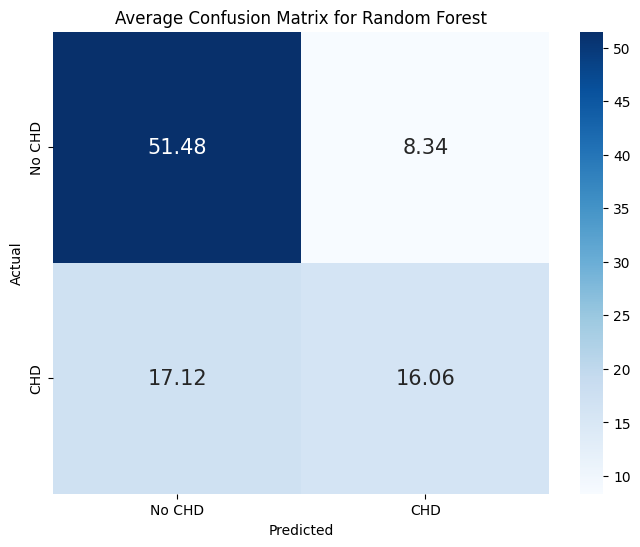

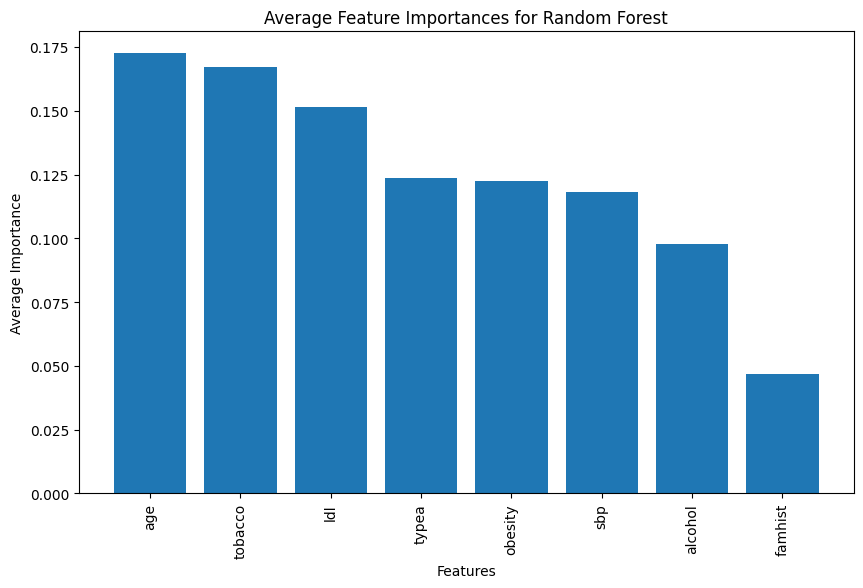

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize variables to store the results
confusion_matrices = []
accuracies = []
classifiers = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    best_accuracy = 0
    best_n_estimators = None
    best_rf_classifier = None

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Find the best number of estimators for the current random state
    for n_estimators in best_estimators_sorted:
        rf_classifier = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators)
        rf_classifier.fit(X_train, y_train)
        
        y_pred_rf = rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_rf)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_estimators = n_estimators
            best_rf_classifier = rf_classifier
    
    # Train the best model for the current random state
    y_pred_rf = best_rf_classifier.predict(X_test)
    
    # Calculate the confusion matrix
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    confusion_matrices.append(conf_matrix_rf)
    accuracies.append(best_accuracy)
    classifiers.append(best_rf_classifier)
    print(f"Best accuracy for random state {random_state}: {best_accuracy:.4f}, Best number of estimators: {best_n_estimators}")

# Calculate the average best number of estimators
avg_best_n_estimators = np.mean([classifier.n_estimators for classifier in classifiers])
print(f"Average Best Number of Estimators: {avg_best_n_estimators}")

# Calculate the average accuracy
avg_accuracy_rf = np.mean(accuracies)
print(f"Average Accuracy: {avg_accuracy_rf:.4f}")

# Find & store the best and worst accuracies
best_accuracy_rf = max(accuracies)
worst_accuracy_rf = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_rf:.4f}")
print(f"Worst Accuracy: {worst_accuracy_rf:.4f}")

# Calculate the average confusion matrix
avg_confusion_matrix_rf = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_rf, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix for Random Forest')
plt.show()

# Plot the average feature importances
plt.figure(figsize=(10, 6))
avg_importances = np.mean([classifier.feature_importances_ for classifier in classifiers], axis=0)
indices = np.argsort(avg_importances)[::-1]
plt.bar(range(X.shape[1]), avg_importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Importance')
plt.title('Average Feature Importances for Random Forest')
plt.show()

#### Comparison with Decision Tree

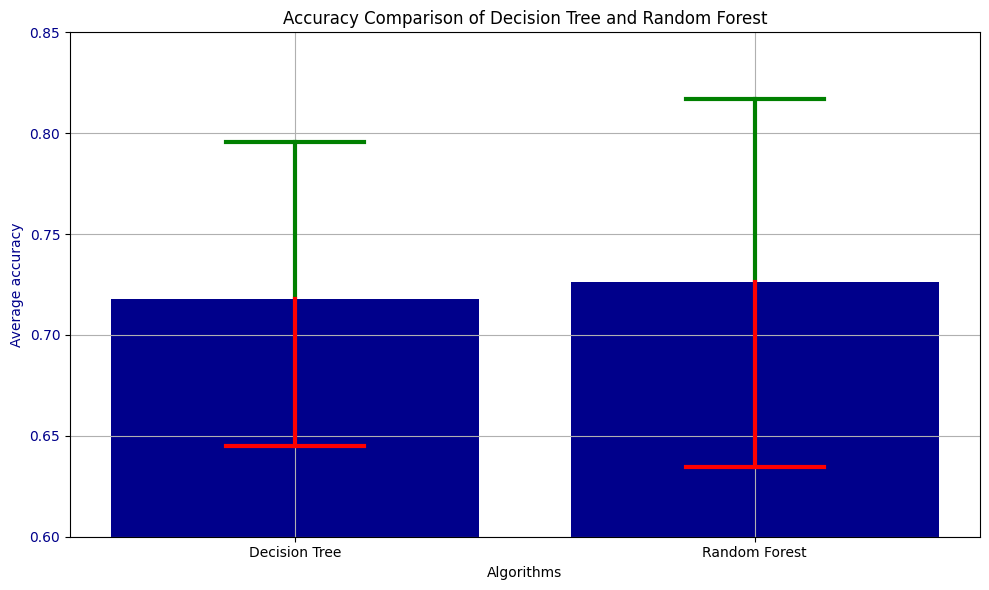

,Metric,Decision Tree,Random Forest,Percentage Change
0,Average Accuracy,0.7181,0.7262,1.13%
1,False Negative Rate,0.5081,0.5160,1.55%
2,Best Accuracy,0.7957,0.8172,2.7%
3,Worst Accuracy,0.6452,0.6344,-1.67%


In [23]:
# Extract the average accuracy and false negative rate from the previous results
algorithms = ['Decision Tree', 'Random Forest']
avg_accuracies = [avg_accuracy_decision_tree, avg_accuracy_rf]

# Calculate the average false negative rates
avg_false_negative_rates = [
    avg_confusion_matrix_decision_tree[1][0] / (avg_confusion_matrix_decision_tree[1][0] + avg_confusion_matrix_decision_tree[1][1]),
    avg_confusion_matrix_rf[1][0] / (avg_confusion_matrix_rf[1][0] + avg_confusion_matrix_rf[1][1])
]

# Extract the best and worst accuracies
best_accuracies = [best_accuracy_decision_tree, best_accuracy_rf]
worst_accuracies = [worst_accuracy_decision_tree, worst_accuracy_rf]

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average accuracy
bars = ax1.bar(algorithms, avg_accuracies, color='darkblue', label='Average Accuracy')

# Plot best and worst accuracy
horizontal_line_width = 0.3
for i, (mean, best, worst) in enumerate(zip(avg_accuracies, best_accuracies, worst_accuracies)):

    # Plot best accuracy
    left = i - horizontal_line_width / 2
    top = best
    right = i + horizontal_line_width / 2
    bottom = best
    plt.plot([i, i], [mean, best], color='green', linewidth=3)
    plt.plot([left, right], [top, top], color='green', linewidth=3)

    # Plot worst accuracy
    left = i - horizontal_line_width / 2
    top = worst
    right = i + horizontal_line_width / 2
    bottom = worst
    plt.plot([i, i], [mean, worst], color='red', linewidth=3)
    plt.plot([left, right], [top, top], color='red', linewidth=3)

ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Average accuracy', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Set y-axis limits to zoom
plt.ylim(0.6, 0.85)

# Add title and legend
plt.title('Accuracy Comparison of Decision Tree and Random Forest')
fig.tight_layout()
plt.grid()
plt.show()

# Create a DataFrame to hold the comparison data
comparison_data = {
    'Metric': ['Average Accuracy', 'False Negative Rate', 'Best Accuracy', 'Worst Accuracy'],
    'Decision Tree': [
        round(avg_accuracy_decision_tree, 4), 
        round(avg_confusion_matrix_decision_tree[1][0] / (avg_confusion_matrix_decision_tree[1][0] + avg_confusion_matrix_decision_tree[1][1]), 4),
        round(best_accuracy_decision_tree, 4),
        round(worst_accuracy_decision_tree, 4)
    ],
    'Random Forest': [
        round(avg_accuracy_rf, 4), 
        round(avg_confusion_matrix_rf[1][0] / (avg_confusion_matrix_rf[1][0] + avg_confusion_matrix_rf[1][1]), 4),
        round(best_accuracy_rf, 4),
        round(worst_accuracy_rf, 4)
    ]
}

# Add percentage comparison
comparison_data['Percentage Change'] = [
    f"{round((comparison_data['Random Forest'][0] - comparison_data['Decision Tree'][0]) / comparison_data['Decision Tree'][0] * 100, 2)}%",
    f"{round((comparison_data['Random Forest'][1] - comparison_data['Decision Tree'][1]) / comparison_data['Decision Tree'][1] * 100, 2)}%",
    f"{round((comparison_data['Random Forest'][2] - comparison_data['Decision Tree'][2]) / comparison_data['Decision Tree'][2] * 100, 2)}%",
    f"{round((comparison_data['Random Forest'][3] - comparison_data['Decision Tree'][3]) / comparison_data['Decision Tree'][3] * 100, 2)}%"
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df

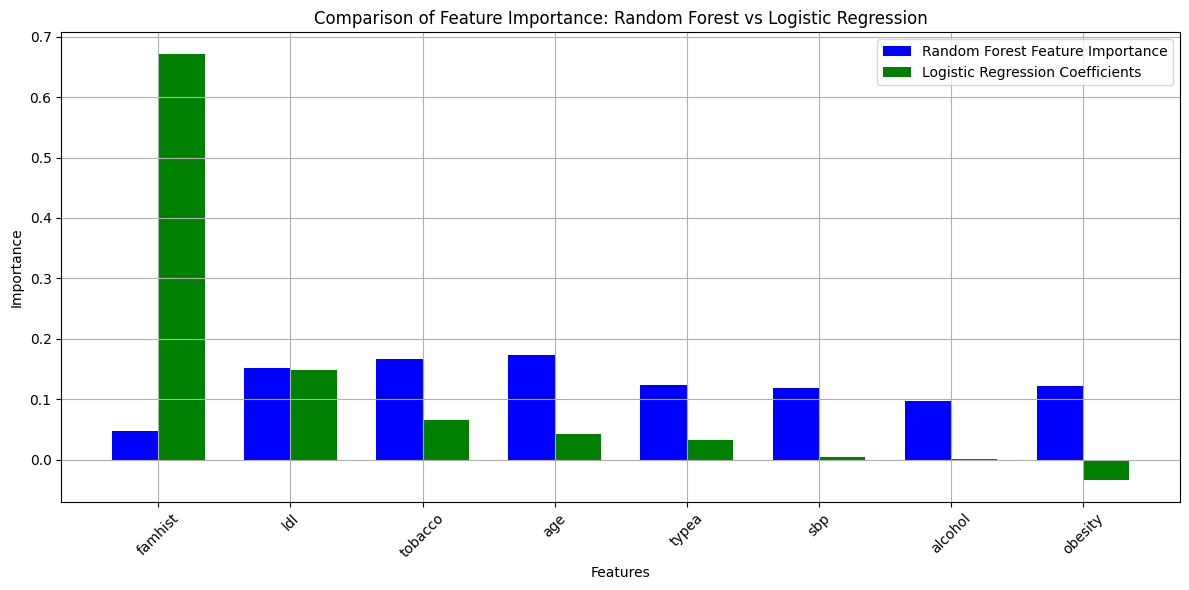

In [24]:
# Calculate the average feature importances for Random Forest
avg_importances_rf = np.mean([classifier.feature_importances_ for classifier in classifiers], axis=0)

# Calculate the average coefficients for Logistic Regression
avg_coefficients_log_reg = avg_coefficients_opt

# Normalize the coefficients to make them comparable to feature importances
normalized_coefficients_log_reg = avg_coefficients_log_reg / np.sum(np.abs(avg_coefficients_log_reg))

# Sort the columns by their importance for logistic regression
sorted_indices = np.argsort(normalized_coefficients_log_reg)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances_rf = avg_importances_rf[sorted_indices]
sorted_coefficients_log_reg = normalized_coefficients_log_reg[sorted_indices]

# Plot the histogram
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(sorted_features))

# Plot Random Forest feature importances
plt.bar(index, sorted_importances_rf, bar_width, label='Random Forest Feature Importance', color='blue')

# Plot Logistic Regression coefficients
plt.bar(index + bar_width, sorted_coefficients_log_reg, bar_width, label='Logistic Regression Coefficients', color='green')

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Comparison of Feature Importance: Random Forest vs Logistic Regression')
plt.xticks(index + bar_width / 2, sorted_features, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

#### Support Vector Machine improved
##### Applying the optimized hyperparameters to the model

Average Accuracy for Optimized SVM: 0.7129032258064515
Best Accuracy: 0.8065
Worst Accuracy: 0.6344
Average Computational Time for Optimized SVM: 0.9632 seconds


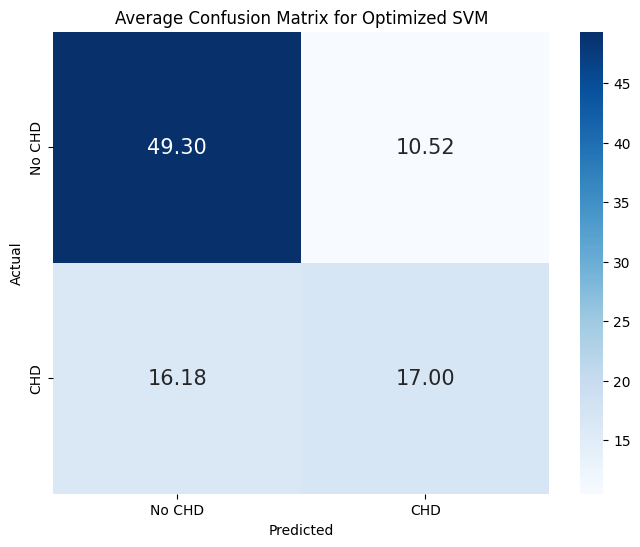

In [48]:
# Initialize variables to store the results
confusion_matrices = []
accuracies = []
times = []

# Run the algorithm for 50 different random states
for random_state in range(50):
    start_time = time.time()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Initialize the SVM model with optimized hyperparameters
    svm = SVC(kernel='linear', C=4, tol=10e-10, random_state=random_state)
    
    # Train the model
    svm.fit(X_train, y_train)
    
    # Make predictions
    y_pred_svm = svm.predict(X_test)
    
    # Evaluate the model
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    accuracies.append(accuracy_svm)
    
    # Calculate the confusion matrix
    conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
    confusion_matrices.append(conf_matrix_svm)
    
    end_time = time.time()
    times.append(end_time - start_time)

# Calculate the average accuracy
avg_accuracy_svm_opt = np.mean(accuracies)
print("Average Accuracy for Optimized SVM:", avg_accuracy_svm_opt)

# Find & store the best and worst accuracies
best_accuracy_svm_opt = max(accuracies)
worst_accuracy_svm_opt = min(accuracies)

# Print the best and worst accuracies
print(f"Best Accuracy: {best_accuracy_svm_opt:.4f}")
print(f"Worst Accuracy: {worst_accuracy_svm_opt:.4f}")

# Calculate and print the average computational time
avg_time_svm_opt = np.mean(times)
print(f"Average Computational Time for Optimized SVM: {avg_time_svm_opt:.4f} seconds")

# Calculate the average confusion matrix
avg_confusion_matrix_svm_opt = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix_svm_opt, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'], annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix for Optimized SVM')
plt.show()

In [49]:
# Create a DataFrame to hold the comparison data
comparison_data_svm = {
    'Metric': ['Average Accuracy', 'False Negative Rate', 'Best Accuracy', 'Worst Accuracy', 'Average Computational Time'],
    'First SVM': [
        round(avg_accuracy_svm, 4), 
        round(avg_confusion_matrix_svm[1][0] / (avg_confusion_matrix_svm[1][0] + avg_confusion_matrix_svm[1][1]), 4),
        round(best_accuracy_svm, 4),
        round(worst_accuracy_svm, 4),
        round(avg_time_svm, 4)
    ],
    'Optimized SVM': [
        round(avg_accuracy_svm_opt, 4), 
        round(avg_confusion_matrix_svm_opt[1][0] / (avg_confusion_matrix_svm_opt[1][0] + avg_confusion_matrix_svm_opt[1][1]), 4),
        round(best_accuracy_svm_opt, 4),
        round(worst_accuracy_svm_opt, 4),
        round(avg_time_svm_opt, 4)
    ]
}

# Add percentage comparison
comparison_data_svm['Percentage Change'] = [
    f"{round((comparison_data_svm['Optimized SVM'][0] - comparison_data_svm['First SVM'][0]) / comparison_data_svm['First SVM'][0] * 100, 2)}%",
    f"{round((comparison_data_svm['Optimized SVM'][1] - comparison_data_svm['First SVM'][1]) / comparison_data_svm['First SVM'][1] * 100, 2)}%",
    f"{round((comparison_data_svm['Optimized SVM'][2] - comparison_data_svm['First SVM'][2]) / comparison_data_svm['First SVM'][2] * 100, 2)}%",
    f"{round((comparison_data_svm['Optimized SVM'][3] - comparison_data_svm['First SVM'][3]) / comparison_data_svm['First SVM'][3] * 100, 2)}%",
    f"{round((comparison_data_svm['Optimized SVM'][4] - comparison_data_svm['First SVM'][4]) / comparison_data_svm['First SVM'][4] * 100, 2)}%"
]

comparison_df_svm = pd.DataFrame(comparison_data_svm)
comparison_df_svm

,Metric,First SVM,Optimized SVM,Percentage Change
0,Average Accuracy,0.7125,0.7129,0.06%
1,False Negative Rate,0.4913,0.4876,-0.75%
2,Best Accuracy,0.8172,0.8065,-1.31%
3,Worst Accuracy,0.6452,0.6344,-1.67%
4,Average Computational Time,0.4063,0.9632,137.07%


### Conclusion of the improvement processes

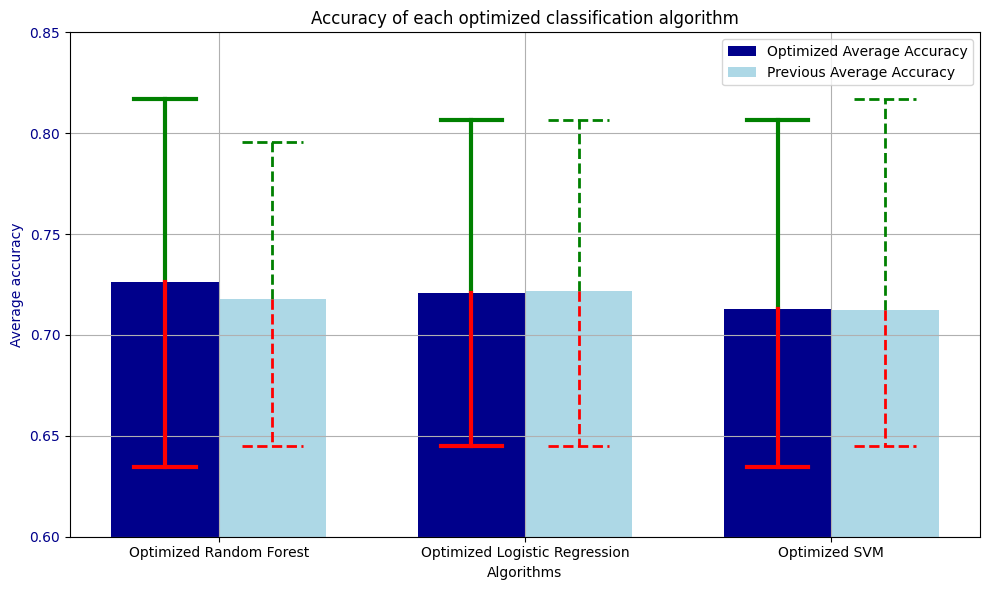

In [74]:
sorted_algorithms = ['Optimized Random Forest', 'Optimized Logistic Regression', 'Optimized SVM']
sorted_avg_accuracies = [avg_accuracy_rf, average_accuracy_logistic_opt, avg_accuracy_svm_opt]
sorted_best_accuracies = [best_accuracy_rf, best_accuracy_logistic_opt, best_accuracy_svm_opt]
sorted_worst_accuracies = [worst_accuracy_rf, worst_accuracy_logistic_opt, worst_accuracy_svm_opt]
sorted_indices = [1, 0, 2]

# Extract the previous average accuracies
previous_avg_accuracies = [average_accuracy_logistic, avg_accuracy_decision_tree, avg_accuracy_svm]
previous_best_accuracies = [best_accuracy_logistic, best_accuracy_decision_tree, best_accuracy_svm]
previous_worst_accuracies = [worst_accuracy_logistic, worst_accuracy_decision_tree, worst_accuracy_svm]

# Sort the previous average accuracies accordingly
sorted_previous_avg_accuracies = [previous_avg_accuracies[i] for i in sorted_indices]
sorted_previous_best_accuracies = [previous_best_accuracies[i] for i in sorted_indices]
sorted_previous_worst_accuracies = [previous_worst_accuracies[i] for i in sorted_indices]

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define the width of the bars
bar_width = 0.35

# Define the positions of the bars
r1 = np.arange(len(sorted_algorithms))
r2 = [x + bar_width for x in r1]

# Plot average accuracy for optimized algorithms
bars1 = ax1.bar(r1, sorted_avg_accuracies, color='darkblue', width=bar_width, label='Optimized Average Accuracy')

# Plot previous average accuracy
bars2 = ax1.bar(r2, sorted_previous_avg_accuracies, color='lightblue', width=bar_width, label='Previous Average Accuracy')

# Plot best and worst accuracy
horizontal_line_width = 0.2
for i, (mean, best, worst, prev_best, prev_worst) in enumerate(zip(sorted_avg_accuracies, sorted_best_accuracies, sorted_worst_accuracies, sorted_previous_best_accuracies, sorted_previous_worst_accuracies)):
    # Plot best accuracy
    left = i - horizontal_line_width / 2
    top = best
    right = i + horizontal_line_width / 2
    bottom = best
    plt.plot([i, i], [mean, best], color='green', linewidth=3)
    plt.plot([left, right], [top, top], color='green', linewidth=3)

    # Plot worst accuracy
    left = i - horizontal_line_width / 2
    top = worst
    right = i + horizontal_line_width / 2
    bottom = worst
    plt.plot([i, i], [mean, worst], color='red', linewidth=3)
    plt.plot([left, right], [top, top], color='red', linewidth=3)

    # Plot previous best accuracy
    left = i + bar_width - horizontal_line_width / 2
    top = prev_best
    right = i + bar_width + horizontal_line_width / 2
    bottom = prev_best
    plt.plot([i + bar_width, i + bar_width], [sorted_previous_avg_accuracies[i], prev_best], color='green', linewidth=2, linestyle='dashed')
    plt.plot([left, right], [top, top], color='green', linewidth=2, linestyle='dashed')

    # Plot previous worst accuracy
    left = i + bar_width - horizontal_line_width / 2
    top = prev_worst
    right = i + bar_width + horizontal_line_width / 2
    bottom = prev_worst
    plt.plot([i + bar_width, i + bar_width], [sorted_previous_avg_accuracies[i], prev_worst], color='red', linewidth=2, linestyle='dashed')
    plt.plot([left, right], [top, top], color='red', linewidth=2, linestyle='dashed')

ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Average accuracy', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Set y-axis limits to zoom
plt.ylim(0.6, 0.85)

# Add title and legend
plt.title('Accuracy of each optimized classification algorithm')
ax1.set_xticks(r1 + bar_width / 2)
ax1.set_xticklabels(sorted_algorithms)
fig.tight_layout()
plt.grid()
plt.legend()
plt.show()

## IV – Additional analyse
### Re-working on the original database

In [3]:
path = (
    r'C:\Users\solal\Documents\Documents\Etudes\ETSIT-UPM\Cursos\PRDL-MLLB'
    r'\Final Report\SAHeart.csv'
)
df = pd.read_csv(path)

if 'row.names' in df.columns:
    df.drop('row.names', axis=1, inplace=True)
df.replace('Present', 1, inplace=True)
df.replace('Absent', 0, inplace=True)
df = df.infer_objects(copy=False)
df.head()

C:\Users\solal\AppData\Local\Temp\ipykernel_7912\3614903900.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('Absent', 0, inplace=True)


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


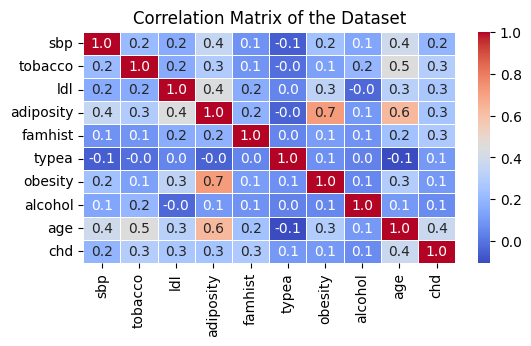

In [4]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f',
            linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')
plt.show()

### First regressions

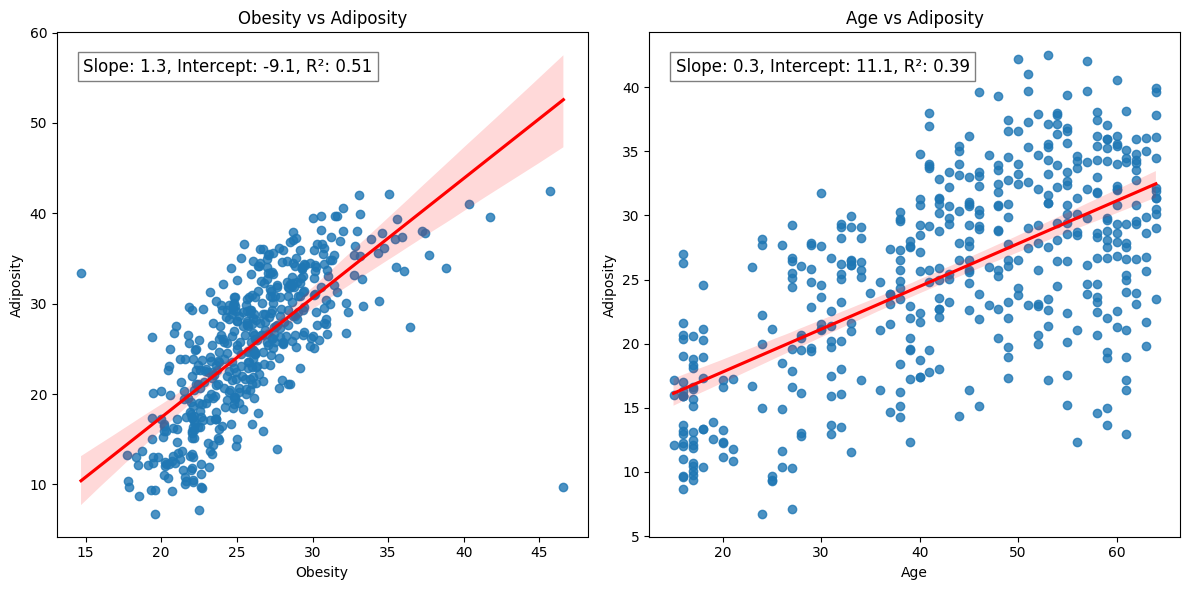

In [5]:
from sklearn.metrics import r2_score

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot regression between 'obesity' and 'adiposity'
sns.regplot(x='obesity', y='adiposity', data=df, line_kws={'color': 'red'}, ax=axes[0])
slope_obesity, intercept_obesity = np.polyfit(df['obesity'], df['adiposity'], 1)
r2_obesity = r2_score(df['adiposity'], np.polyval([slope_obesity, intercept_obesity], df['obesity']))
axes[0].set_title('Obesity vs Adiposity')
axes[0].set_xlabel('Obesity')
axes[0].set_ylabel('Adiposity')
axes[0].text(0.05, 0.95, f'Slope: {slope_obesity:.1f}, Intercept: {intercept_obesity:.1f}, R²: {r2_obesity:.2f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot regression between 'age' and 'adiposity'
sns.regplot(x='age', y='adiposity', data=df, line_kws={'color': 'red'}, ax=axes[1])
slope_age, intercept_age = np.polyfit(df['age'], df['adiposity'], 1)
r2_age = r2_score(df['adiposity'], np.polyval([slope_age, intercept_age], df['age']))
axes[1].set_title('Age vs Adiposity')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Adiposity')
axes[1].text(0.05, 0.95, f'Slope: {slope_age:.1f}, Intercept: {intercept_age:.1f}, R²: {r2_age:.2f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [6]:
# Create a summary of the regressions
regression_summary_1D = {
    'Regression': ['Obesity vs Adiposity', 'Age vs Adiposity'],
    'Slope': [slope_obesity, slope_age],
    'Intercept': [intercept_obesity, intercept_age],
    'R²': [r2_obesity, r2_age]
}

# Create a DataFrame for the summary
regression_summary_df = pd.DataFrame(regression_summary_1D)

# Display the summary DataFrame
print(regression_summary_df)

             Regression     Slope  Intercept        R²
0  Obesity vs Adiposity  1.323145  -9.053395  0.513453
1      Age vs Adiposity  0.333382  11.132643  0.391819


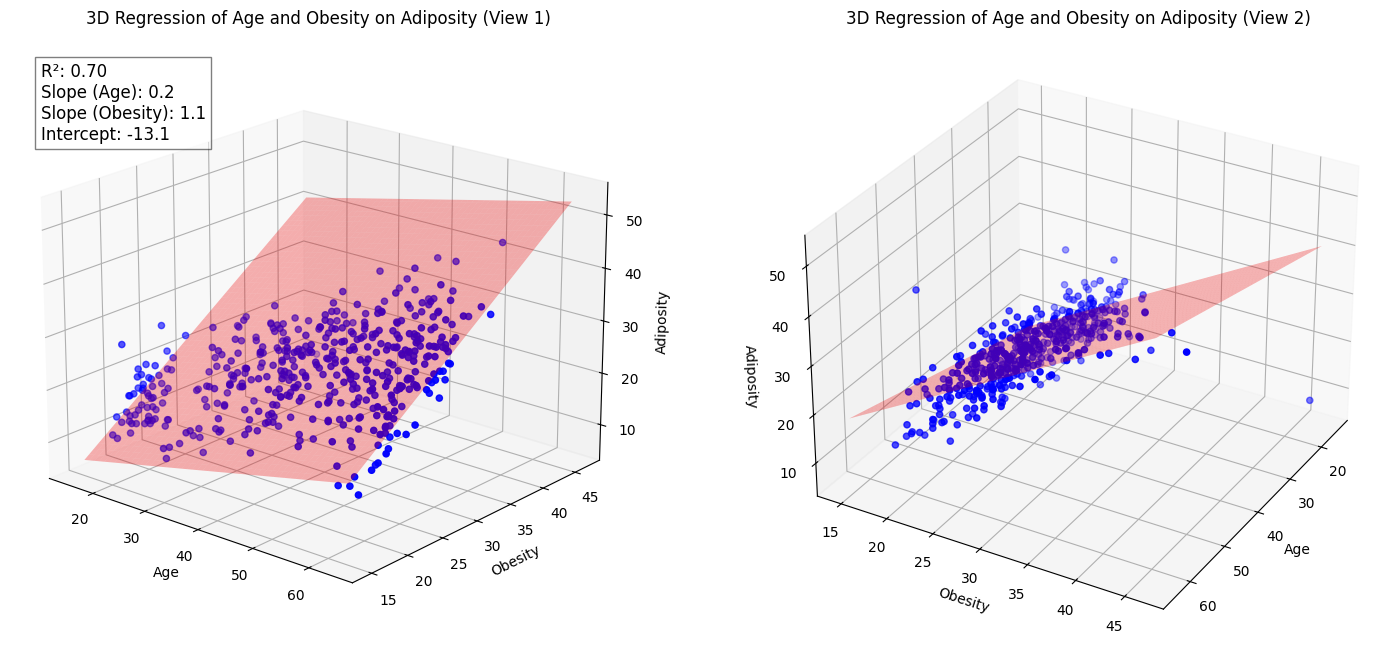

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Prepare the data
X = df[['age', 'obesity']]
y = df['adiposity']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Create a meshgrid for plotting
age_range = np.linspace(X['age'].min(), X['age'].max(), 100)
obesity_range = np.linspace(X['obesity'].min(), X['obesity'].max(), 100)
age_grid, obesity_grid = np.meshgrid(age_range, obesity_range)

# Convert the meshgrid to a DataFrame with appropriate column names
meshgrid_df = pd.DataFrame(np.c_[age_grid.ravel(), obesity_grid.ravel()], columns=['age', 'obesity'])
adiposity_pred = model.predict(meshgrid_df).reshape(age_grid.shape)

# Calculate the R² coefficient
r2 = model.score(X, y)

# Get the slopes and intercept
slope_age = model.coef_[0]
slope_obesity = model.coef_[1]
intercept = model.intercept_

# Plot the 3D regression with two different points of view
fig = plt.figure(figsize=(18, 8))

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X['age'], X['obesity'], y, color='blue', label='Data points')
ax1.plot_surface(age_grid, obesity_grid, adiposity_pred, color='red', alpha=0.3, label='Regression plane')
ax1.set_xlabel('Age')
ax1.set_ylabel('Obesity')
ax1.set_zlabel('Adiposity')
ax1.set_title('3D Regression of Age and Obesity on Adiposity (View 1)')
ax1.text2D(0.05, 0.95, f'R²: {r2:.2f}\nSlope (Age): {slope_age:.1f}\nSlope (Obesity): {slope_obesity:.1f}\nIntercept: {intercept:.1f}', 
           transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
ax1.view_init(elev=20, azim=-50)  # Adjust the elevation and azimuthal angle as needed

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X['age'], X['obesity'], y, color='blue', label='Data points')
ax2.plot_surface(age_grid, obesity_grid, adiposity_pred, color='red', alpha=0.3, label='Regression plane')
ax2.set_xlabel('Age')
ax2.set_ylabel('Obesity')
ax2.set_zlabel('Adiposity')
ax2.set_title('3D Regression of Age and Obesity on Adiposity (View 2)')
ax2.view_init(elev=30, azim=30)  # Adjust the elevation and azimuthal angle as needed

plt.show()

### Working on the hypothesis

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

# Prepare the data
X = df[['age', 'obesity']]
y = df['adiposity']
X = sm.add_constant(X)  # Add a constant term for the intercept

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# 1. Constant Variance (Homoscedasticity): Assumes equal variance of errors across all predictor values.
# Perform the Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_results = dict(zip(labels, bp_test))
print(f"Breusch-Pagan test p-value: {bp_test_results['p-value']}")
if bp_test_results['p-value'] > 0.05:
    print("Breusch-Pagan test: Homoscedasticity validated")
else:
    print("Breusch-Pagan test: Homoscedasticity not validated")

print()  # Line break

# 2. Independence of Errors: Assumes uncorrelated errors.
# Perform the Durbin-Watson test for autocorrelation
dw_test = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')
if 1.5 < dw_test < 2.5:
    print("Durbin-Watson test: Independence of errors validated")
else:
    print("Durbin-Watson test: Independence of errors not validated")

print()  # Line break

# Perform the Breusch-Godfrey test for autocorrelation
bg_test = acorr_breusch_godfrey(model, nlags=2)
bg_test_results = dict(zip(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], bg_test))
print(f"Breusch-Godfrey test p-value: {bg_test_results['p-value']}")
if bg_test_results['p-value'] > 0.05:
    print("Breusch-Godfrey test: Independence of errors validated")
else:
    print("Breusch-Godfrey test: Independence of errors not validated")

print()  # Line break

# 4. Lack of Perfect Multicollinearity: Predictor variables should not be perfectly linearly dependent.
# Calculate the Variance Inflation Factor (VIF) for each predictor
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns  # Includes the constant term
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
if all(vif_data.loc[vif_data['feature'] != 'const', 'VIF'] < 10):
    print("VIF test: Absence of perfect multicollinearity validated")
else:
    print("VIF test: Potential perfect multicollinearity, test not validated")

print()  # Line break

# 4. Zero Mean of Residuals: Assumes the mean of residuals is zero.
mean_residuals = model.resid.mean()
print(f'Mean of residuals: {mean_residuals}')
threshold = 0.01 * (y.max() - y.min())
if abs(mean_residuals) < threshold:
    print("Zero mean of residuals test: Validated")
else:
    print("Zero mean of residuals test: Not validated")

Breusch-Pagan test p-value: 0.015334589189202568
Breusch-Pagan test: Homoscedasticity not validated

Durbin-Watson statistic: 1.9787613861154498
Durbin-Watson test: Independence of errors validated

Breusch-Godfrey test p-value: 0.9054555101367658
Breusch-Godfrey test: Independence of errors validated

   feature        VIF
0    const  40.678001
1      age   1.093056
2  obesity   1.093056
VIF test: Absence of perfect multicollinearity validated

Mean of residuals: 3.560403535248121e-14
Zero mean of residuals test: Validated


#### Residual plots to visually assess the variance

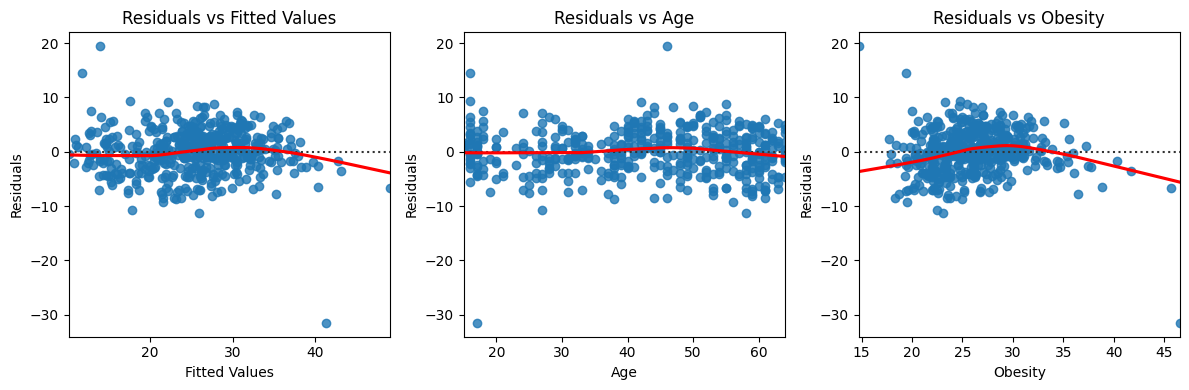

In [21]:
# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Get the residuals
residuals = model.resid

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot residuals vs fitted values
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, ax=axes[0], line_kws={'color': 'red'})
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# Plot residuals vs age
sns.residplot(x=X['age'], y=residuals, lowess=True, ax=axes[1], line_kws={'color': 'red'})
axes[1].set_title('Residuals vs Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Residuals')

# Plot residuals vs obesity
sns.residplot(x=X['obesity'], y=residuals, lowess=True, ax=axes[2], line_kws={'color': 'red'})
axes[2].set_title('Residuals vs Obesity')
axes[2].set_xlabel('Obesity')
axes[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

#### Resolving the heteroscedasticity issue with logarithmic transformation

In [29]:
# Apply logarithmic transformation to the obesity variable
df_log = df.copy()
df_log['log_obesity'] = np.log(df_log['obesity'])

# Prepare the data
X_log = df_log[['age', 'log_obesity']]
X_log = sm.add_constant(X_log)  # Add a constant term for the intercept

# Fit the linear regression model
model_log = sm.OLS(y, X_log).fit()

# Perform the Breusch-Pagan test for heteroscedasticity
bp_test_log = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_results_log = dict(zip(labels, bp_test_log))

# Print the results
print(f"Breusch-Pagan test p-value: {bp_test_results_log['p-value']}")
if bp_test_results_log['p-value'] > 0.05:
    print("Breusch-Pagan test: Homoscedasticity validated")
else:
    print("Breusch-Pagan test: Homoscedasticity not validated")


Breusch-Pagan test p-value: 0.4500195247360883
Breusch-Pagan test: Homoscedasticity validated


In [30]:
# Print the summary of the regression model
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:              adiposity   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     584.0
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          7.47e-127
Time:                        21:44:20   Log-Likelihood:                -1310.6
No. Observations:                 462   AIC:                             2627.
Df Residuals:                     459   BIC:                             2640.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -81.3046      4.058    -20.038      

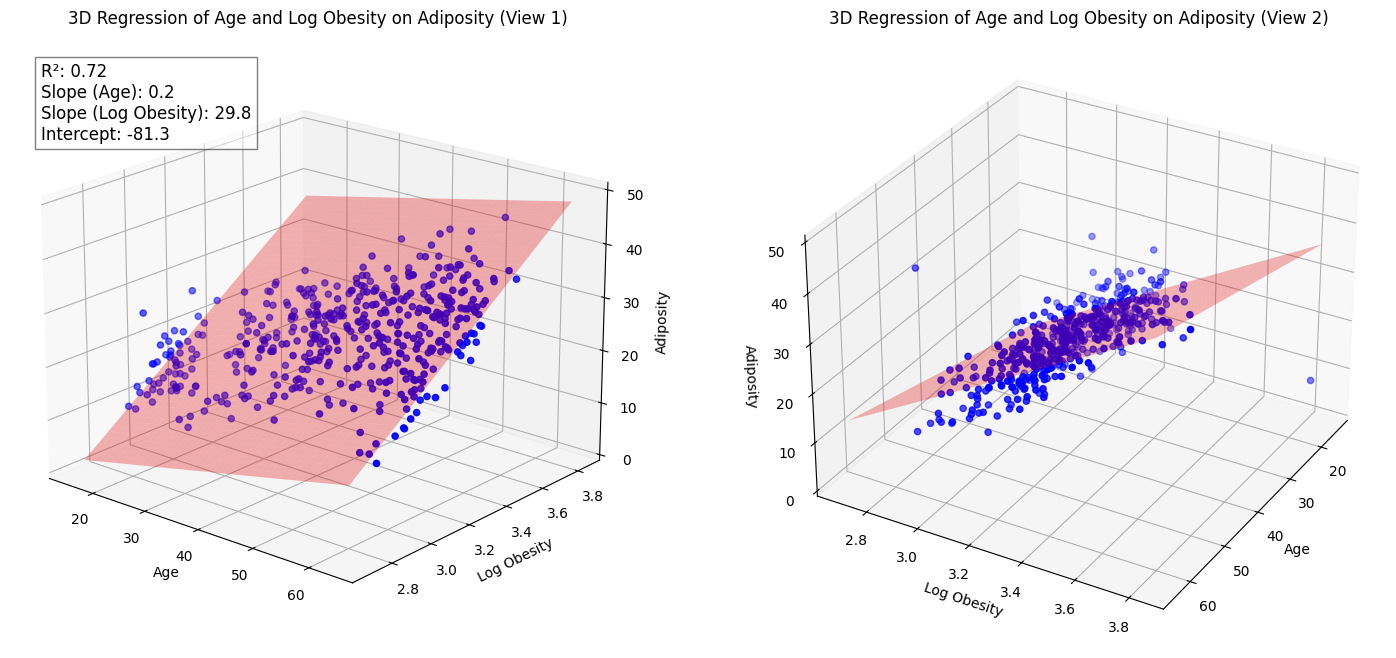

In [35]:
# Prepare the data
X_log = df_log[['age', 'log_obesity']]
y = df['adiposity']

# Fit the linear regression model
model_log = LinearRegression()
model_log.fit(X_log, y)

# Calculate the R² coefficient
r2_log = model_log.score(X_log, y)

# Get the slopes and intercept
slope_age_log = model_log.coef_[0]
slope_log_obesity = model_log.coef_[1]
intercept_log = model_log.intercept_

# Create a meshgrid for plotting
age_range = np.linspace(X_log['age'].min(), X_log['age'].max(), 100)
log_obesity_range = np.linspace(X_log['log_obesity'].min(), X_log['log_obesity'].max(), 100)
age_grid, log_obesity_grid = np.meshgrid(age_range, log_obesity_range)

# Convert the meshgrid to a DataFrame with appropriate column names
meshgrid_df_log = pd.DataFrame(np.c_[age_grid.ravel(), log_obesity_grid.ravel()], columns=['age', 'log_obesity'])
adiposity_pred_log = model_log.predict(meshgrid_df_log).reshape(age_grid.shape)

# Plot the 3D regression with two different points of view
fig = plt.figure(figsize=(18, 8))

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_log['age'], X_log['log_obesity'], y, color='blue', label='Data points')
ax1.plot_surface(age_grid, log_obesity_grid, adiposity_pred_log, color='red', alpha=0.3, label='Regression plane')
ax1.set_xlabel('Age')
ax1.set_ylabel('Log Obesity')
ax1.set_zlabel('Adiposity')
ax1.text2D(0.05, 0.95, f'R²: {r2_log:.2f}\nSlope (Age): {slope_age_log:.1f}\nSlope (Log Obesity): {slope_log_obesity:.1f}\nIntercept: {intercept_log:.1f}', 
           transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
ax1.set_title('3D Regression of Age and Log Obesity on Adiposity (View 1)')
ax1.view_init(elev=20, azim=-50)  # Adjust the elevation and azimuthal angle as needed

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_log['age'], X_log['log_obesity'], y, color='blue', label='Data points')
ax2.plot_surface(age_grid, log_obesity_grid, adiposity_pred_log, color='red', alpha=0.3, label='Regression plane')
ax2.set_xlabel('Age')
ax2.set_ylabel('Log Obesity')
ax2.set_zlabel('Adiposity')
ax2.set_title('3D Regression of Age and Log Obesity on Adiposity (View 2)')
ax2.view_init(elev=30, azim=30)  # Adjust the elevation and azimuthal angle as needed

plt.show()